In [1]:
setwd("/data/wangjl/scScripts/")
getwd()

[1] "/data/wangjl/scScripts"

In [2]:
subDir="backup/a1_2/"
if( ! dir.exists( subDir ) ){
    dir.create( subDir )
}
outputRoot=paste0( getwd(),"/", subDir)
outputRoot

[1] "/data/wangjl/scScripts/backup/a1_2/"

In [3]:
Sys.time()

[1] "2021-03-03 20:08:04 CST"

> Aim: using server to analyse PBMC cell type

In [83]:
library(ggplot2)
library(patchwork)
library(tidyverse)
library(Cairo)

library("SeuratObject")

library(Seurat)
library(dplyr)

# Analyse by Seurat

## load data

In [7]:
filePath="backup/filtered_feature_bc_matrix/"
pbmc.data <- Read10X(data.dir = filePath)

pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc10k", min.cells = 3, min.features = 200)
pbmc

An object of class Seurat 
22860 features across 10884 samples within 1 assay 
Active assay: RNA (22860 features)

## preprocessing and QC

In [13]:
#计算红细胞比例
HB.genes <- c("HBA1","HBA2","HBB","HBD","HBE1","HBG1","HBG2","HBM","HBQ1","HBZ")
HB_m <- match(HB.genes, rownames(pbmc@assays$RNA)) 
HB.genes <- rownames(pbmc@assays$RNA)[HB_m]
HB.genes <- HB.genes[!is.na(HB.genes)]
#
pbmc[["percent.HB"]]<-PercentageFeatureSet(pbmc, features=HB.genes) 
head(pbmc@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt percent.HB
AAACCCAGTATATGGA pbmc10k      886       343         45.0338600 0         
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0         
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 0         
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0         
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 0         
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0

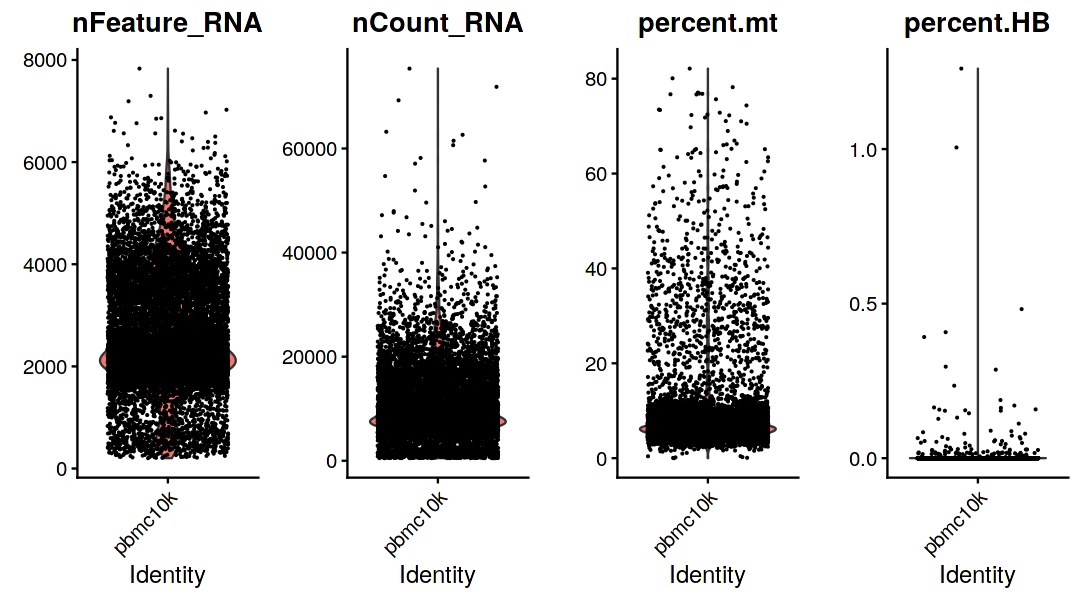

In [15]:
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")
# Visualize QC metrics as a violin plot

options(repr.plot.width=9, repr.plot.height=5)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.HB"), ncol = 4, pt.size=0.1)

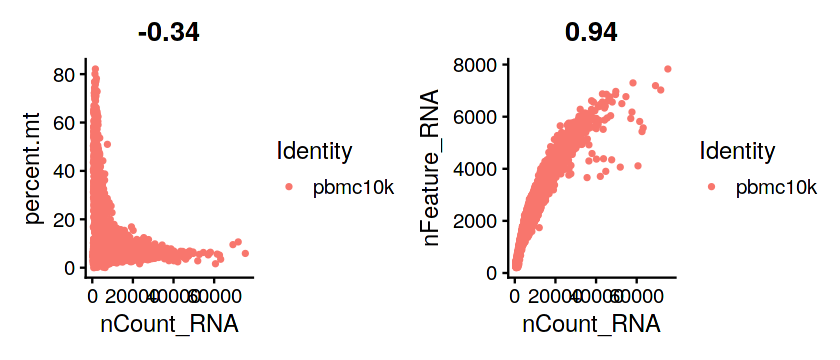

In [19]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

options(repr.plot.width=7, repr.plot.height=3)
plot1 + plot2

In [20]:
# filter by MT
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 7000 & percent.mt < 30)
pbmc

An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)

In [21]:
# 标准化
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)
# HVG
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)
# scale
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



## PCA

In [22]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc),  
               nfeatures.print = 5, # default 30
               npcs = 100) # default 50

PC_ 1 
Positive:  IL32, LTB, TRAC, CD3D, TRBC2 
Negative:  FGL2, FCN1, IFI30, CST3, MNDA 
PC_ 2 
Positive:  IL32, CD3D, CD3G, CD7, TRAC 
Negative:  BCL11A, NIBAN3, IGHM, CD79A, BANK1 
PC_ 3 
Positive:  CCR7, MS4A1, CD79A, LINC00926, LTB 
Negative:  GZMB, CLIC3, NKG7, C12orf75, GNLY 
PC_ 4 
Positive:  GNLY, NKG7, KLRD1, PRF1, CST7 
Negative:  LILRA4, CLEC4C, SERPINF1, SCT, TPM2 
PC_ 5 
Positive:  S100A12, ITGAM, VCAN, CES1, PADI4 
Negative:  CDKN1C, HES4, CTSL, BATF3, TCF7L2 



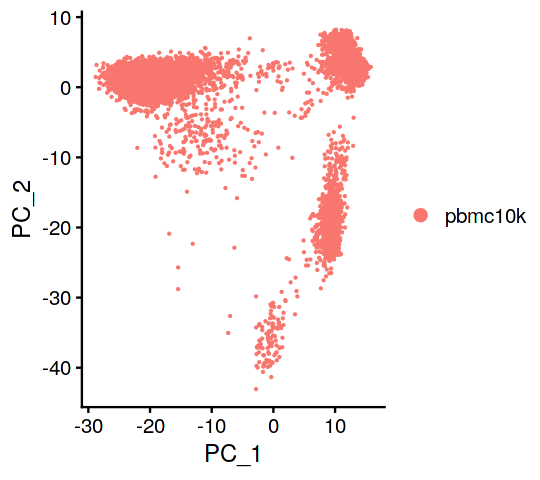

In [24]:
options(repr.plot.width=4.5, repr.plot.height=4)
DimPlot(pbmc, reduction = "pca")

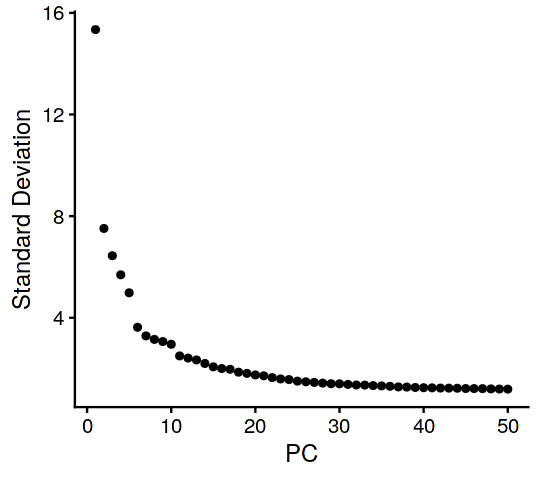

In [25]:
ElbowPlot(pbmc, ndims = 50)

## 细胞分群

In [26]:
pc.use=1:20

pbmc <- FindNeighbors(pbmc, dims = pc.use, # decided by ElbowPlot, JackStrawPlot and DimHeatmap;
                     k.param = 20) # k怎么设置？太大了分类太少。

pbmc <- FindClusters(pbmc, resolution = 0.8) # 0.5分到20 个类; 0.8分到23个类
pbmc

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10441
Number of edges: 381756

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8953
Number of communities: 23
Elapsed time: 1 seconds


An object of class Seurat 
22860 features across 10441 samples within 1 assay 
Active assay: RNA (22860 features)
 1 dimensional reduction calculated: pca

### QC again

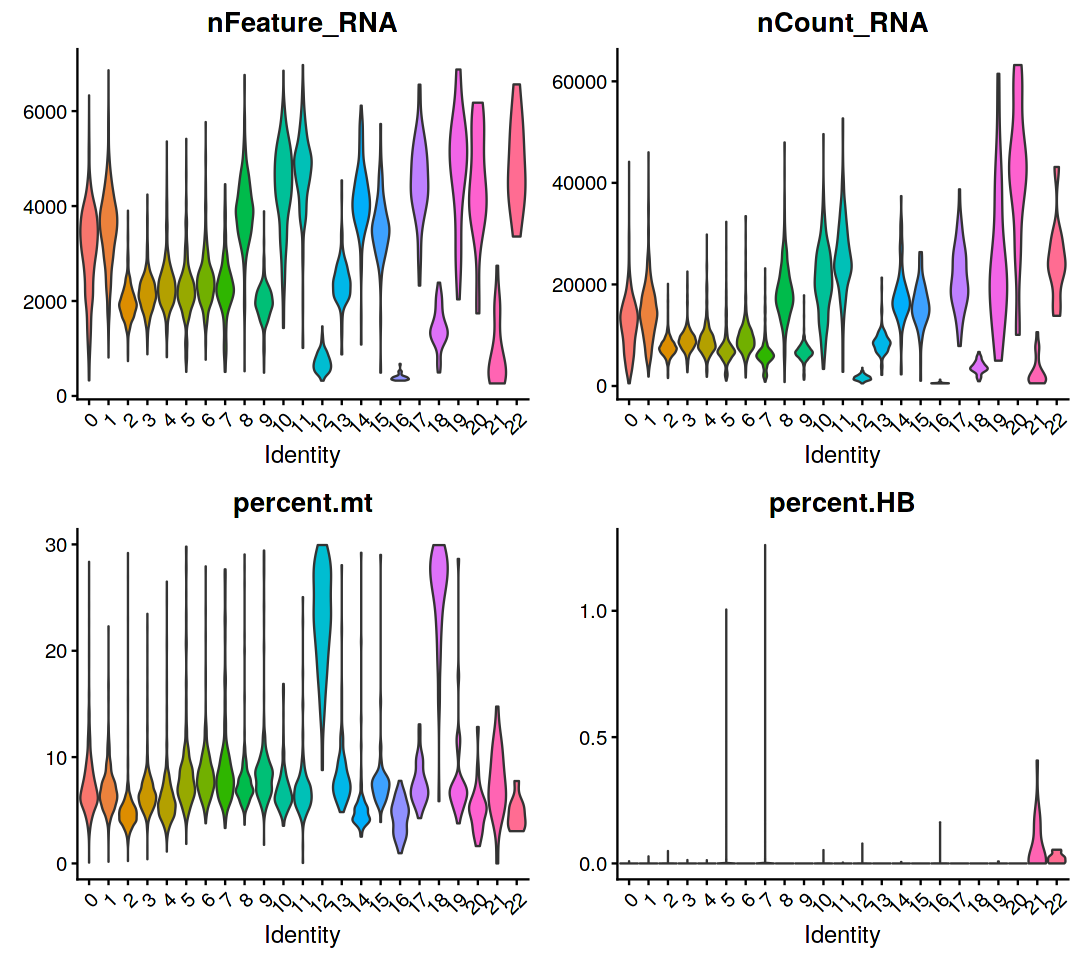

In [30]:
options(repr.plot.width=9, repr.plot.height=8)
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt","percent.HB"), ncol = 2, pt.size=0)

# remove 16; 12?, 18?, 21?

In [33]:
pbmc=subset(pbmc, idents = c(16), invert=T)
table(Idents(pbmc))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1518 1514 1405 1238 1157  735  497  442  423  368  242  181  167  128  113   68 
  17   18   19   20   21   22 
  51   43   32   23   23    9 

In [34]:
# 重新据类
pc.use=1:20
pbmc <- FindNeighbors(pbmc, dims = pc.use, # decided by ElbowPlot, JackStrawPlot and DimHeatmap;
                     k.param = 20) # k怎么设置？太大了分类太少。

pbmc <- FindClusters(pbmc, resolution = 0.8) # 0.5分到20 个类; 0.8分到21个类
pbmc

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10377
Number of edges: 379986

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8938
Number of communities: 21
Elapsed time: 1 seconds


An object of class Seurat 
22860 features across 10377 samples within 1 assay 
Active assay: RNA (22860 features)
 1 dimensional reduction calculated: pca

In [35]:
table(Idents(pbmc))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1584 1457 1441 1236 1121  737  497  451  423  368  242  172  167  128  113   68 
  16   17   18   19   20 
  51   43   32   23   23 

## UMAP and tSNE

In [36]:
pbmc <- RunTSNE(pbmc, dims = 1:20)
pbmc <- RunUMAP(pbmc, dims = 1:20)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:03:55 UMAP embedding parameters a = 0.9922 b = 1.112

17:03:55 Read 10377 rows and found 20 numeric columns

17:03:55 Using Annoy for neighbor search, n_neighbors = 30

17:03:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:03:56 Writing NN index file to temp file /tmp/RtmpDhB7bv/file72f1380a3bdf

17:03:56 Searching Annoy index using 1 thread, search_k = 3000

17:03:59 Annoy recall = 100%

17:03:59 Commencing smooth kNN distance calibration using 1 thread

17:04:00 Initializing fr

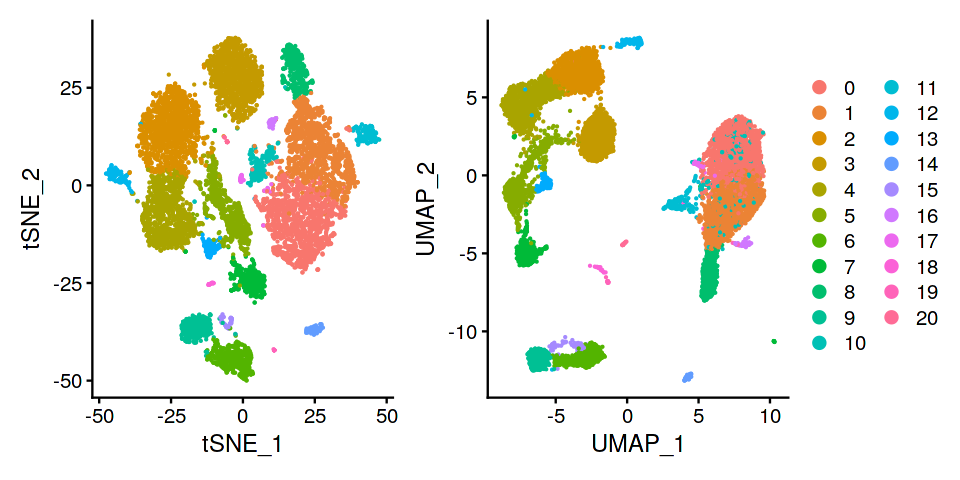

In [38]:
p1=DimPlot(pbmc, reduction = "tsne")
p2=DimPlot(pbmc, reduction = "umap")

options(repr.plot.width=8, repr.plot.height=4)
p1+p2+plot_layout(guides = 'collect')

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


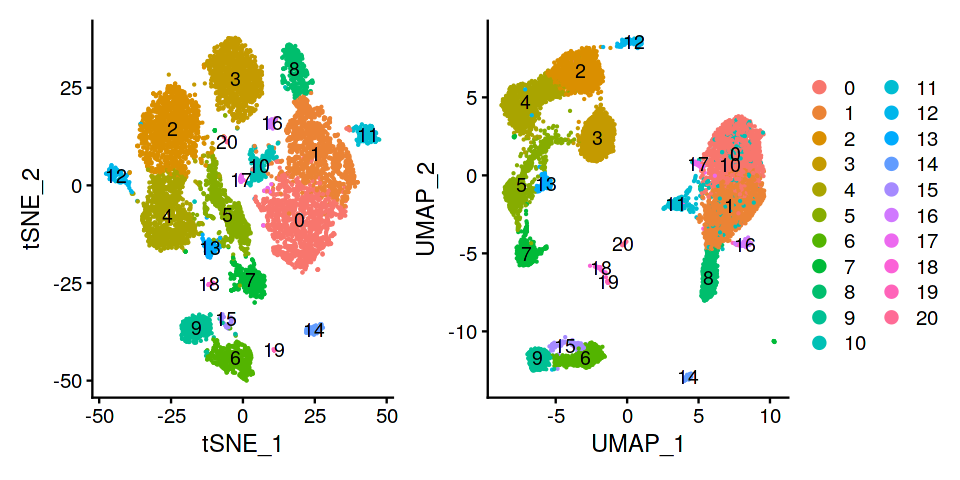

In [39]:
# add labels
p1=DimPlot(pbmc, reduction = "tsne", label=T)
p2=DimPlot(pbmc, reduction = "umap", label=T)

options(repr.plot.width=8, repr.plot.height=4)
p1+p2+plot_layout(guides = 'collect')

## find marker

In [40]:
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC) # long time! 17:08 - 

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20



p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster gene      
1   0.000000e+00 2.5696605 0.999 0.494  0.000000e+00 0       S100A8    
2   0.000000e+00 2.3712392 0.999 0.626  0.000000e+00 0       S100A9    
3   0.000000e+00 1.4805976 0.999 0.337  0.000000e+00 1       FGL2      
4   0.000000e+00 1.4528092 0.984 0.323  0.000000e+00 1       MARCKS    
5   0.000000e+00 0.8698733 0.924 0.376  0.000000e+00 2       TCF7      
6   0.000000e+00 0.8537195 0.863 0.293  0.000000e+00 2       CCR7      
7   0.000000e+00 1.6376338 0.982 0.096  0.000000e+00 3       CD8B      
8   0.000000e+00 1.3342506 0.738 0.036  0.000000e+00 3       LINC02446 
9   0.000000e+00 1.2257023 0.996 0.515  0.000000e+00 4       IL32      
10  0.000000e+00 1.1555938 0.999 0.691  0.000000e+00 4       LTB       
11  0.000000e+00 2.4519032 0.957 0.154  0.000000e+00 5       CCL5      
12  0.000000e+00 2.0271525 0.621 0.055  0.000000e+00 5       GZMH      
13  0.000000e+00 2.2182717 0.996 0.115  0.000000e+00 6       CD79A     
14  0.000000e+00 2.1979350 0.996 0.074  0.000000e+00 6       MS4A1     
15  0.000000e+00 3.2673584 0.976 0.191  0.000000e+00 7       GNLY      
16  0.000000e+00 2.7284196 0.976 0.258  0.000000e+00 7       NKG7      
17  0.000000e+00 2.5346202 0.957 0.040  0.000000e+00 8       CDKN1C    
18  0.000000e+00 2.4723245 1.000 0.198  0.000000e+00 8       FCGR3A    
19  0.000000e+00 2.6840110 0.997 0.162  0.000000e+00 9       IGHM      
20  0.000000e+00 2.4817820 0.967 0.025  0.000000e+00 9       TCL1A     
21  6.999985e-62 0.6725631 0.996 0.561  1.600197e-57 10      S100A8    
22  3.719788e-58 0.7312056 1.000 0.676  8.503436e-54 10      S100A9    
23 3.676667e-132 2.0751037 1.000 0.355 8.404860e-128 11      HLA-DQA1  
24 1.990956e-107 1.8952755 1.000 0.570 4.551325e-103 11      HLA-DPB1  
25 6.952015e-100 1.3015205 1.000 0.999  1.589231e-95 12      MT-CYB    
26  2.259322e-97 1.6540036 1.000 1.000  5.164811e-93 12      MALAT1    
27  0.000000e+00 1.9970467 0.977 0.067  0.000000e+00 13      GZMK      
28 4.279170e-208 2.4383944 0.992 0.134 9.782183e-204 13      KLRB1     
29 1.813802e-253 2.8988799 0.982 0.091 4.146351e-249 14      GZMB      
30 1.192598e-178 2.8996547 0.469 0.024 2.726280e-174 14      PTGDS     
31  2.206646e-77 1.2747566 0.985 0.152  5.044392e-73 15      CD79A     
32  2.591008e-53 1.2592618 0.882 0.187  5.923045e-49 15      IGHM      
33  8.041629e-76 0.9689944 1.000 0.114  1.838316e-71 16      MS4A1     
34  3.553794e-58 1.0188698 1.000 0.153  8.123974e-54 16      CD79A     
35  2.056495e-29 2.0858848 1.000 0.904  4.701147e-25 17      NEAT1     
36  1.978835e-27 2.0532396 0.977 0.500  4.523617e-23 17      AC020916.1
37  8.630519e-40 2.5233308 1.000 0.230  1.972937e-35 18      STMN1     
38  4.017009e-04 3.0318294 0.281 0.092  1.000000e+00 18      IGHA1     
39  2.564610e-42 5.5584318 0.870 0.091  5.862699e-38 19      IGHA1     
40  1.217664e-09 5.5537347 0.609 0.145  2.783580e-05 19      IGLC2     
41  0.000000e+00 5.6085970 1.000 0.010  0.000000e+00 20      PPBP      
42  3.454043e-29 5.1588344 1.000 0.230  7.895942e-25 20      NRGN

In [42]:
genes.marker=pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC)
head(genes.marker)

p_val avg_logFC pct.1 pct.2 p_val_adj cluster gene  
1 0     2.5696605 0.999 0.494 0         0       S100A8
2 0     2.3712392 0.999 0.626 0         0       S100A9
3 0     1.4805976 0.999 0.337 0         1       FGL2  
4 0     1.4528092 0.984 0.323 0         1       MARCKS
5 0     0.8698733 0.924 0.376 0         2       TCF7  
6 0     0.8537195 0.863 0.293 0         2       CCR7

### 可视化

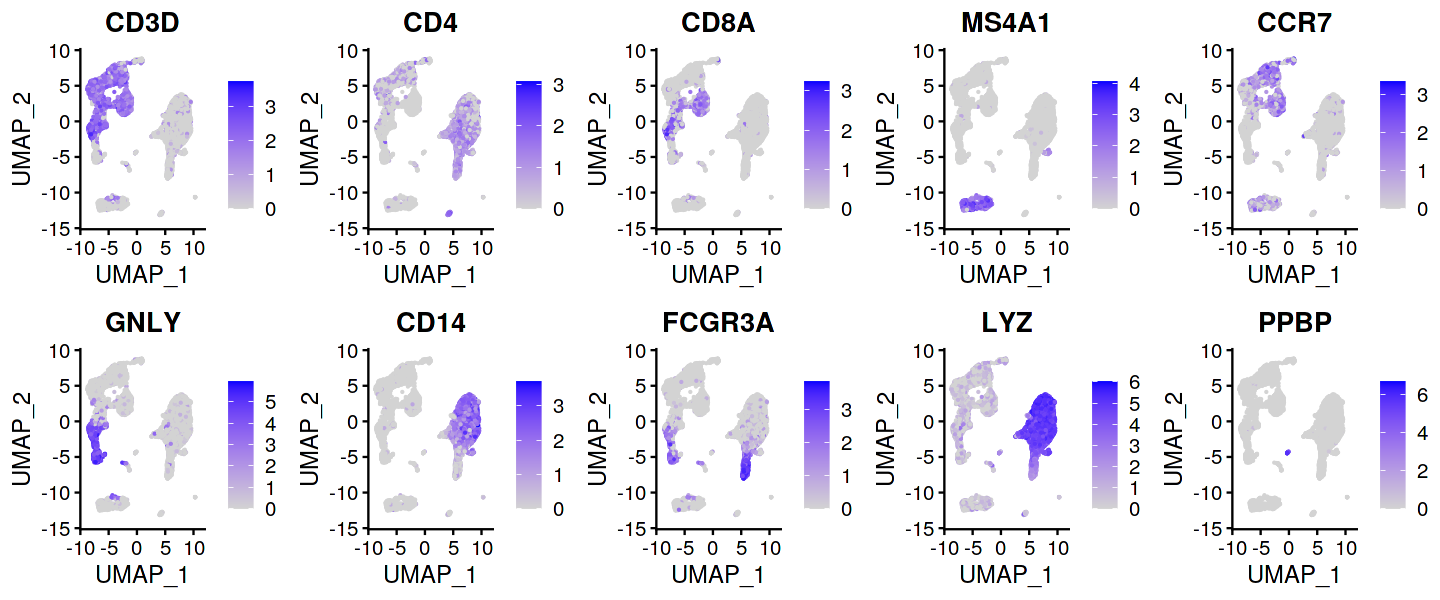

In [54]:
options(repr.plot.width=12, repr.plot.height=5)

FeaturePlot(pbmc, features = c("CD3D","CD4","CD8A", "MS4A1", "CCR7",
    "GNLY", "CD14",  "FCGR3A", "LYZ", "PPBP"), ncol=5, reduction = "umap")

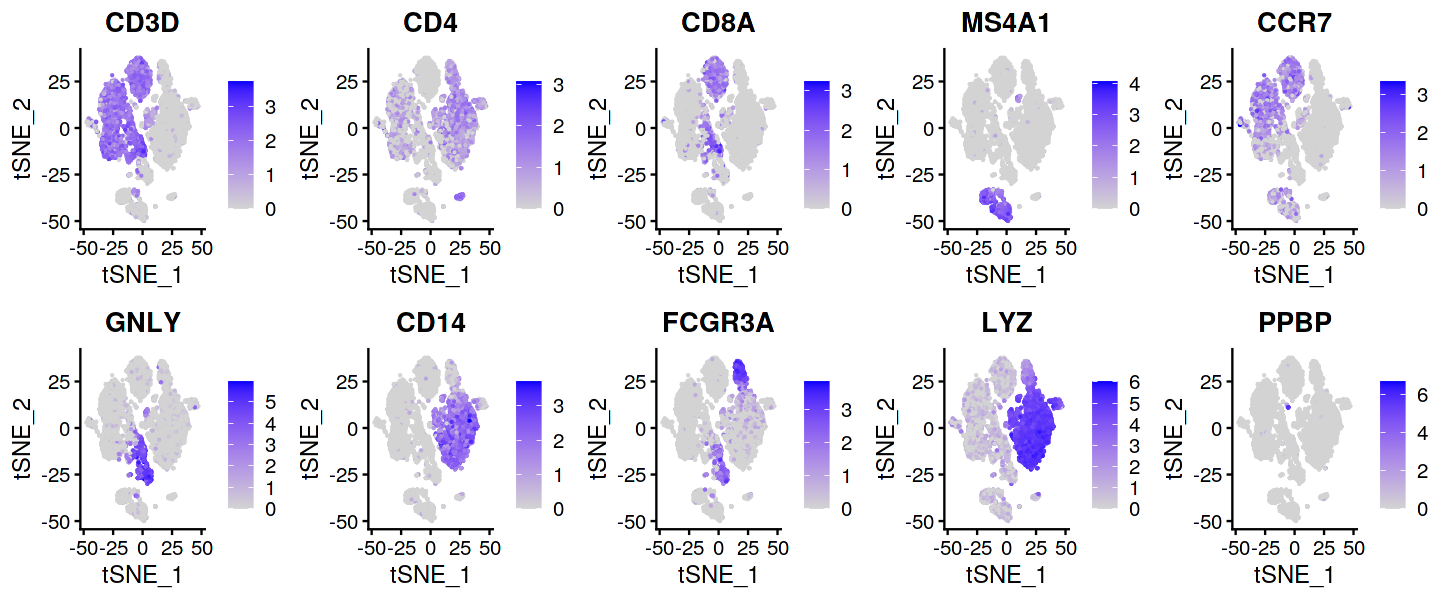

In [55]:
options(repr.plot.width=12, repr.plot.height=5)
FeaturePlot(pbmc, features = c("CD3D","CD4","CD8A", "MS4A1", "CCR7",
    "GNLY", "CD14",  "FCGR3A", "LYZ", "PPBP"), ncol=5, reduction = "tsne")

[1] 210   7

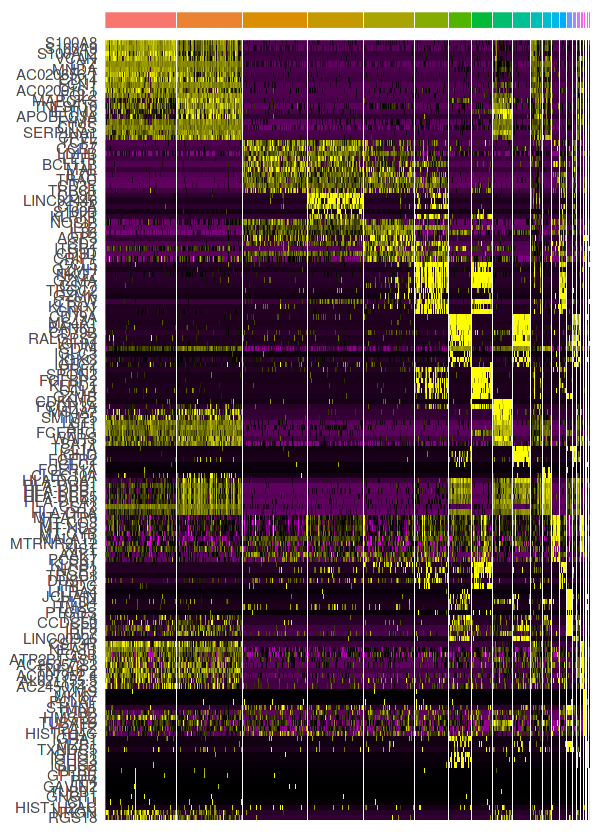

In [57]:
top10 <- pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
dim(top10)

options(repr.plot.width=5, repr.plot.height=7)
DoHeatmap(pbmc, features = top10$gene, label = F )  + NoLegend()

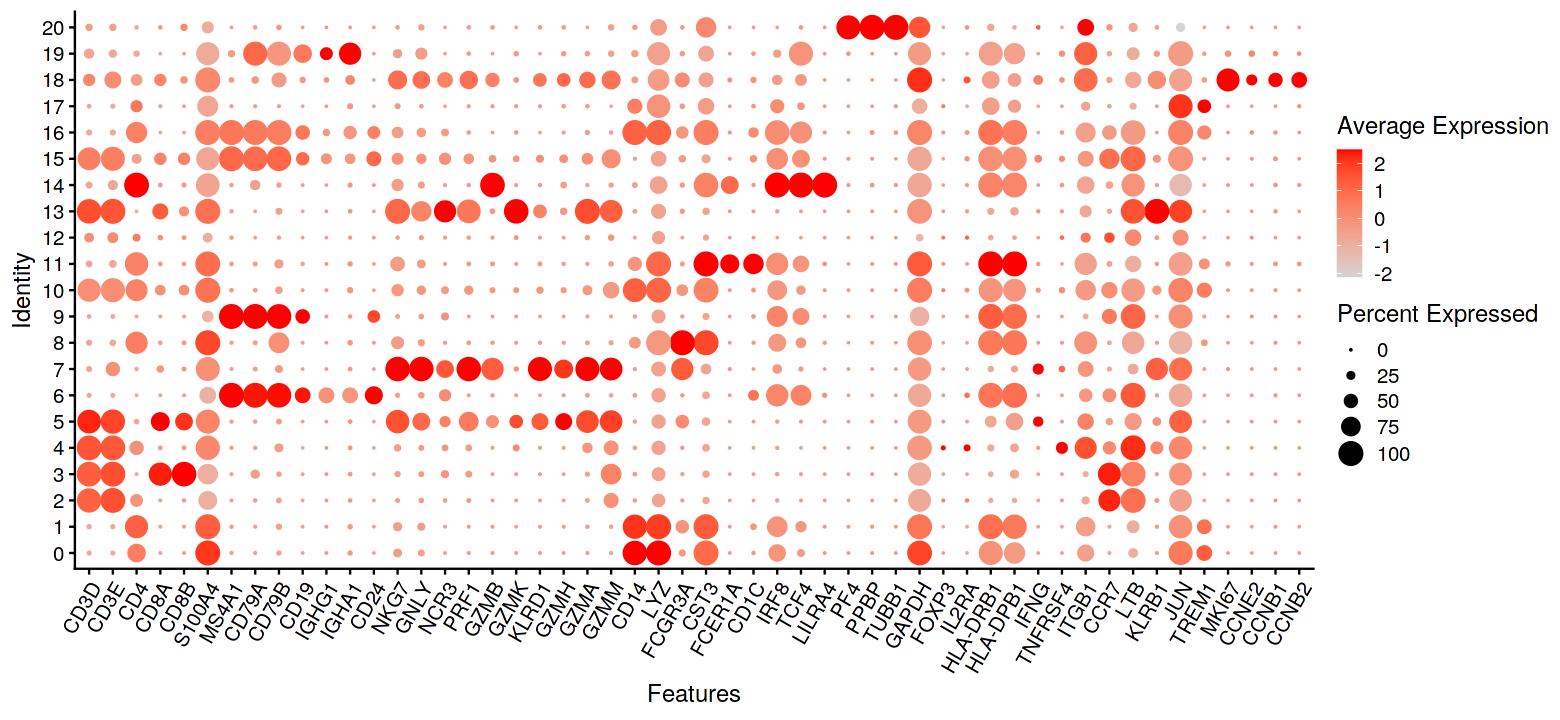

In [59]:
genelist.byHand = c(
    "CD3D","CD3E", "CD4", #naive CD4
    'CD8A','CD8B', #CD8
    "S100A4",  #mem CD4
    "MS4A1",'CD79A',"CD79B","CD19","IGHG1","IGHA1","CD24", #B
    
    "NKG7","GNLY", "NCR3","PRF1","GZMB","GZMK","KLRD1", #NK
    "GZMH", "GZMA","GZMM", 
    "CD14",'LYZ', "FCGR3A", #mono
    
    "CST3", # DC 
    "FCER1A", 'CD1C', #DC
    "IRF8", "TCF4", "LILRA4", #pDC
    "PF4", "PPBP","TUBB1","GAPDH", #Platelet
    "FOXP3", "IL2RA", "HLA-DRB1", "HLA-DPB1", "IFNG","TNFRSF4", #"OX40",
    "ITGB1","CCR7", "LTB", "KLRB1","JUN", #发育过程
    
    # TREM1 (Triggering Receptor Expressed On Myeloid Cells 1) 
    "TREM1", #16 expressed on myeloid cells.
    #Stimulates neutrophil and monocyte-mediated inflammatory responses. 
    
    "MKI67","CCNE2","CCNB1","CCNB2") #cell cycle

# 这些标记基因在不同亚群细胞的表达量热图或者小提琴图展示一下，
# 就明白了为什么它们可以作为标记基因，来对细胞亚群进行命名了。

genelist.byHand=unique(genelist.byHand)

p = DotPlot(pbmc, features = rev( genelist.byHand ) , 
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=13, repr.plot.height=6)
p

#ggsave( paste0(outputRoot,'01_dotplot_eg.pdf'), p, width = 12, height = 6)

## saveRDS

In [103]:
saveRDS(pbmc, file = paste0(outputRoot,"pbmc10k_final.rds") ) #long time: 2min

# azimuth server

In [31]:
library(ggplot2)
library(patchwork)

library(dplyr)

library(Seurat)

if(0){
    
    library(tidyverse)
    library(Cairo)

    library("SeuratObject")
}

## prepare counts matrix

In [16]:
#scRNA=pbmc

scRNA=readRDS(  paste0(outputRoot,"pbmc10k_final.rds")  )
scRNA

An object of class Seurat 
22860 features across 10377 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, tsne, umap

In [61]:
# 提取counts矩阵
count <- GetAssayData(scRNA, assay = "RNA", slot = "counts")
saveRDS(count, paste0(outputRoot, "count.rds" ) )

## upload to server

In [ ]:
#1. 上传到官网Azimuth，点左侧的 browser: 
# http://azimuth.satijalab.org/app/azimuth  or 新版本 https://azimuth.hubmapconsortium.org/
# use: https://app.azimuth.hubmapconsortium.org/app/human-pbmc 出问题。
# http://azimuth.satijalab.org/app/azimuth

#2. 质控参数确定后，点击Map cells to reference就可以鉴定细胞类型了。
#3. 点击左侧的Download，在正文下载数据。azimuth_pred.tsv azimuth_umap.Rds

## afterwards

In [39]:
scRNA=pbmc

In [40]:
scRNA

An object of class Seurat 
22860 features across 10377 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, tsne, umap

In [58]:
Idents(scRNA)="seurat_clusters"
head(scRNA@active.ident)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
               0               13                1                7 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
               0               10 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20

In [44]:
# download cell type
predictions <- read.delim( paste0( outputRoot, 'azimuth_pred.tsv'), row.names = 1)
head(predictions)

# 
cellIDs=as.character( intersect( rownames(scRNA@meta.data), rownames(predictions) ) )
length(cellIDs)
head(cellIDs)

predictions=predictions[cellIDs,]
dim(predictions) #10065 3


library(Seurat)
scRNA=subset(scRNA, cells = cellIDs)
#
scRNA = AddMetaData(
    object = scRNA,
    metadata = predictions)
scRNA

predicted.id predicted.score mapping.score
AAACCCAGTATCGTAC CD14 Mono    0.9672643       0.7140327    
AAACCCAGTCGGTGAA MAIT         1.0000000       0.9839320    
AAACCCAGTTAGAAAC CD14 Mono    1.0000000       0.8350170    
AAACCCAGTTATCTTC NK           1.0000000       0.9262804    
AAACCCAGTTGCCGAC CD14 Mono    1.0000000       0.9543941    
AAACCCAGTTTCCCAC CD14 Mono    0.9790744       0.8250486

[1] 10065

[1] "AAACCCAGTATCGTAC" "AAACCCAGTCGGTGAA" "AAACCCAGTTAGAAAC" "AAACCCAGTTATCTTC"
[5] "AAACCCAGTTGCCGAC" "AAACCCAGTTTCCCAC"

[1] 10065     3

An object of class Seurat 
22860 features across 10065 samples within 1 assay 
Active assay: RNA (22860 features)
 3 dimensional reductions calculated: pca, tsne, umap

In [45]:
head(scRNA@meta.data)

orig.ident nCount_RNA nFeature_RNA percent.mt percent.HB
AAACCCAGTATCGTAC pbmc10k     1628       749          0.4299754 0         
AAACCCAGTCGGTGAA pbmc10k     6590      1867         10.3034901 0         
AAACCCAGTTAGAAAC pbmc10k    17318      3809          5.4913962 0         
AAACCCAGTTATCTTC pbmc10k     3526      1516         13.4997164 0         
AAACCCAGTTGCCGAC pbmc10k     6228      2110          6.0533076 0         
AAACCCAGTTTCCCAC pbmc10k    22044      4598          6.5278534 0         
                 RNA_snn_res.0.8 seurat_clusters predicted.id predicted.score
AAACCCAGTATCGTAC 0               0               CD14 Mono    0.9672643      
AAACCCAGTCGGTGAA 13              13              MAIT         1.0000000      
AAACCCAGTTAGAAAC 1               1               CD14 Mono    1.0000000      
AAACCCAGTTATCTTC 7               7               NK           1.0000000      
AAACCCAGTTGCCGAC 0               0               CD14 Mono    1.0000000      
AAACCCAGTTTCCCAC 10              10              CD14 Mono    0.9790744      
                 mapping.score
AAACCCAGTATCGTAC 0.7140327    
AAACCCAGTCGGTGAA 0.9839320    
AAACCCAGTTAGAAAC 0.8350170    
AAACCCAGTTATCTTC 0.9262804    
AAACCCAGTTGCCGAC 0.9543941    
AAACCCAGTTTCCCAC 0.8250486

### cell number barplot for each cluster

[1]   -1.136   34.936  -31.700 3170.000


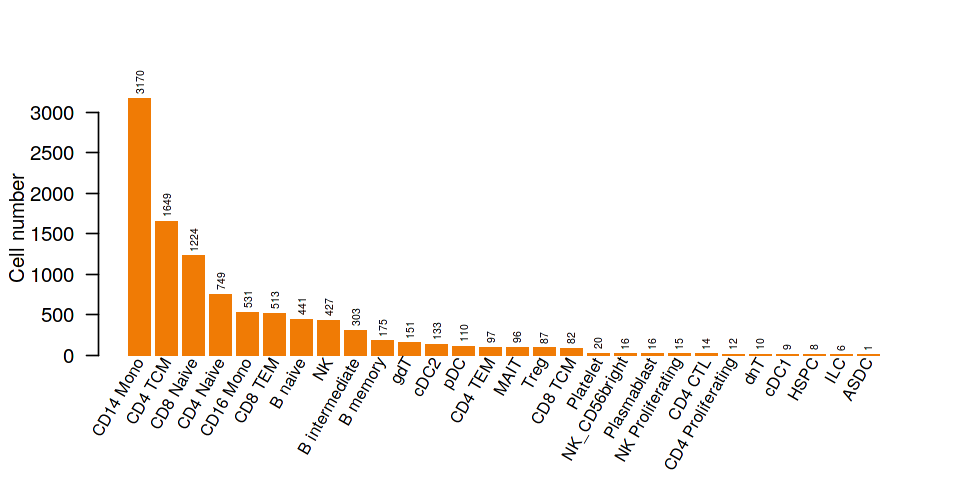

In [281]:
# bar plot for each column in meta.data
myBarPlot=function(scRNA, group.by="seurat_clusters",textPosY=-150, angle=60, isShow=F){
    # 1. data
    df1=table(scRNA@meta.data[[group.by]])
    df1=df1[order( -unname(df1) )] #order
    if(isShow){print(df1)}

    # 2. plot
    xPos = barplot( df1, xaxt="n",#xaxt="n"不要x坐标轴
                   col="#F07B05",
                   las=2, #坐标轴垂直与轴
                   ylab="Cell number",
                   border = NA) #bar不要边框
    # text on x axis
    # print(par("usr"))
    text(x=xPos, y= textPosY, labels=names(df1),
         cex=0.8, #字体是默认的倍数
         col="black",
         xpd=TRUE, #允许绘制在绘图区外
         adj=1, #adj=1右上对齐
         srt=angle) #倾斜
    # text on top of bar
    text(x=xPos, y=unname(df1)+50, labels=unname(df1),
         cex=0.5, #字体是默认的倍数
         col="black",
         xpd=TRUE, #允许绘制在绘图区外
         adj=0, #adj=1右上对齐
         srt=90) #倾斜
}

options(repr.plot.width=8, repr.plot.height=4)
myBarPlot(scRNA, "predicted.id", textPosY=-50)

[1]   -0.80   26.20  -15.73 1573.00


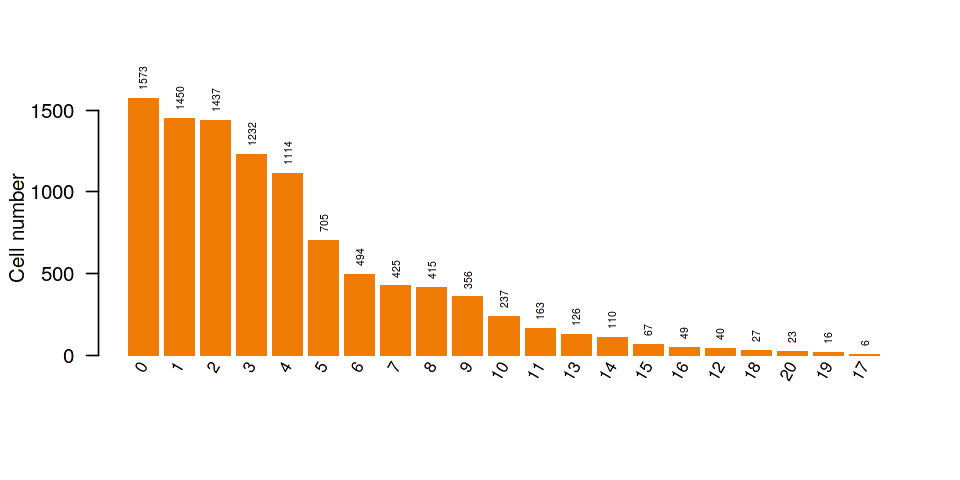

In [282]:
options(repr.plot.width=8, repr.plot.height=4)
myBarPlot(scRNA, "seurat_clusters", textPosY=-50)

In [46]:
# 可能版本不对。R3.6 用old server没问题。 
if(0){
    projected.umap <- readRDS( paste0( outputRoot,'azimuth_umap.Rds') )
    projected.umap

    scRNA <- scRNA2[, Cells(projected.umap)]
    scRNA[['umap.proj']] <- projected.umap
    scRNA

    head(scRNA@meta.data)
}

### DimPlot

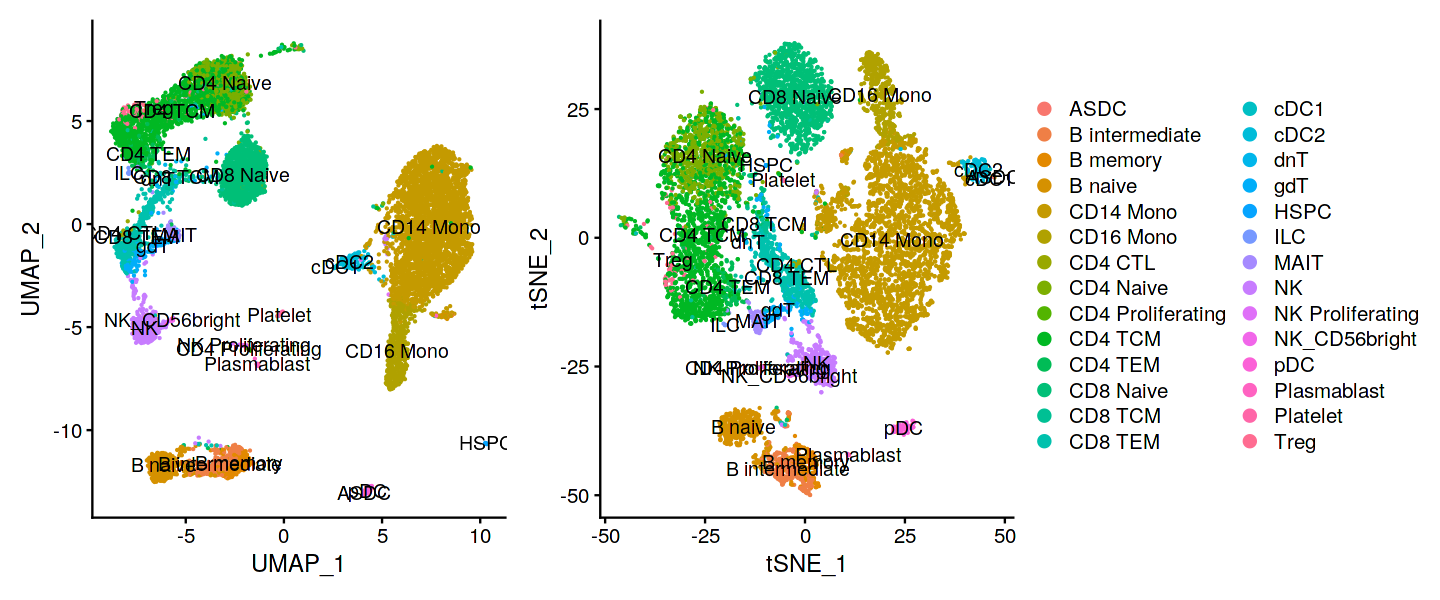

In [47]:
p1=DimPlot(scRNA, group.by="predicted.id", label=T)
p2=DimPlot(scRNA, group.by="predicted.id", label=T, reduction="tsne")

options(repr.plot.width=12, repr.plot.height=5)
p1+p2+plot_layout(guides = 'collect')

## 高亮显示一类细胞

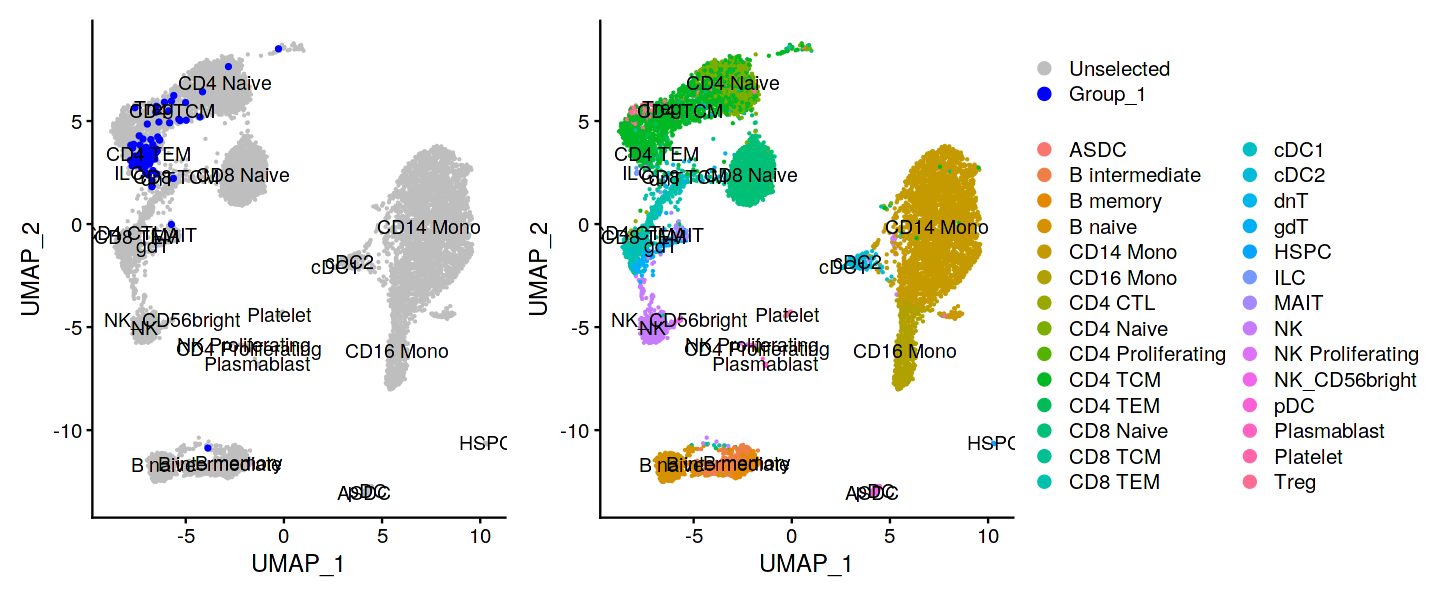

In [124]:
#
Idents(scRNA)="predicted.id"
sub1 <- WhichCells(scRNA, idents = c("CD8 Naive") )
sub2 <- WhichCells(scRNA, idents = c( "CD4 TEM") )
p1=DimPlot(scRNA, label=T, group.by="predicted.id", cells.highlight= list(sub2), 
        cols.highlight = c("blue"), cols= "grey")

by_2="predicted.id"
# p1=DimPlot(scRNA, group.by=by_2, label=T)
p2=DimPlot(scRNA, group.by=by_2, label=T)

options(repr.plot.width=12, repr.plot.height=5)
p1+p2 +plot_layout(guides = 'collect')

## dot plot ( important )

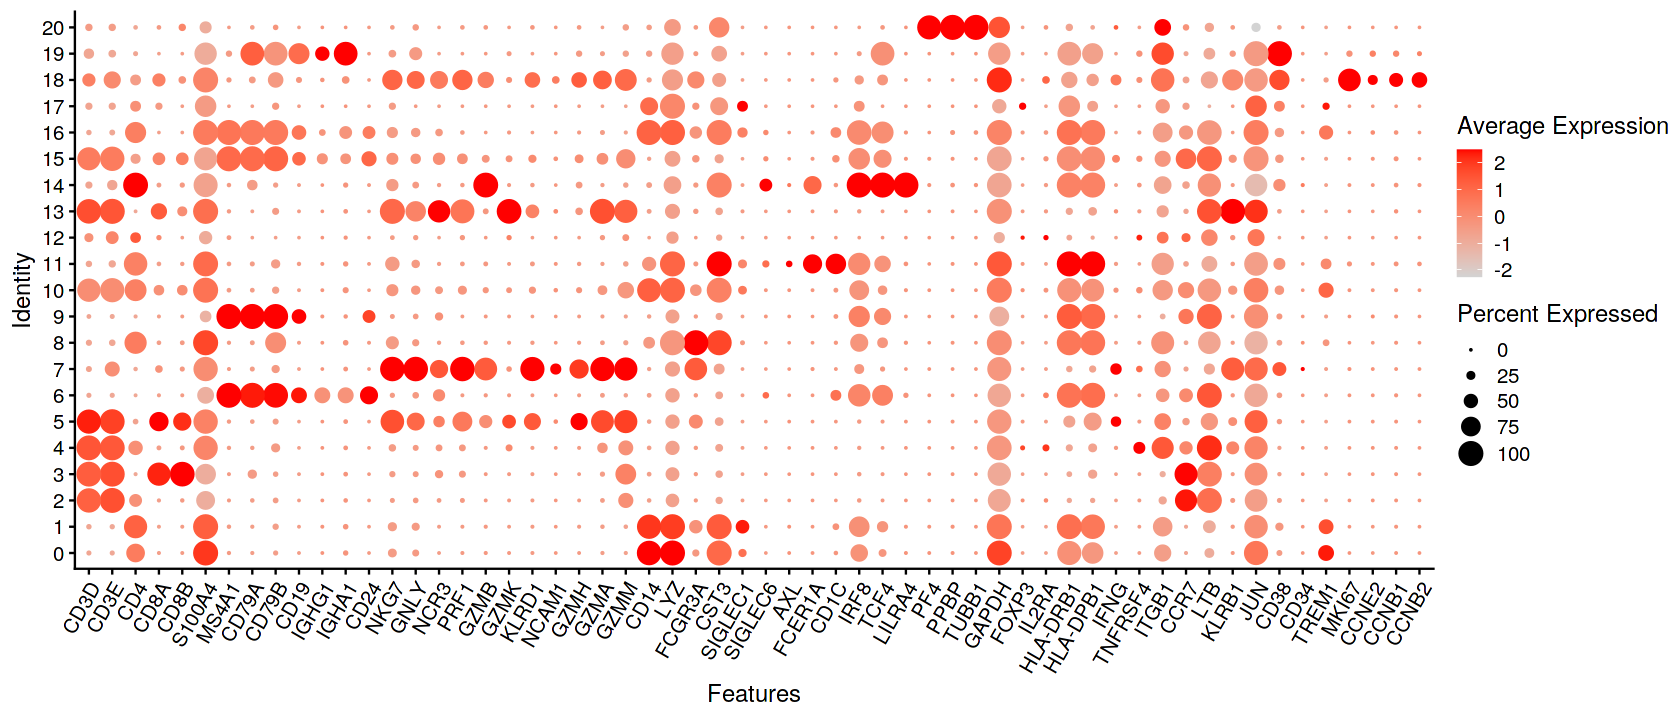

In [302]:
# 表达AXL、SIGLEC1和SIGLEC6抗原的一类DC细胞，被命名为AS DC。
#   AS DC群体进一步划分为传统定义的浆细胞样DC（pDC）和CD1C+常规DC（cDC）门捕获的两个群体

genelist.byHand = c(
    "CD3D","CD3E", "CD4", #naive CD4
    'CD8A','CD8B', #CD8
    "S100A4",  #mem CD4
    "MS4A1",'CD79A',"CD79B","CD19","IGHG1","IGHA1","CD24", #B
    
    "NKG7","GNLY", "NCR3","PRF1","GZMB","GZMK","KLRD1", #NK
    "NCAM1", #NCAM1(CD56) NK_CD56
    "GZMH", "GZMA","GZMM", 
    "CD14",'LYZ', "FCGR3A", #mono
    
    "CST3","SIGLEC1","SIGLEC6","AXL", # DC 
    "FCER1A", 'CD1C', #DC
    "IRF8", "TCF4", "LILRA4", #pDC
    "PF4", "PPBP","TUBB1","GAPDH", #Platelet
    "FOXP3", "IL2RA", "HLA-DRB1", "HLA-DPB1", "IFNG","TNFRSF4", #"OX40",
    "ITGB1","CCR7", "LTB", "KLRB1","JUN", #发育过程
    
    "CD38","CD34",
    
    # TREM1 (Triggering Receptor Expressed On Myeloid Cells 1) 
    "TREM1", #16 expressed on myeloid cells.
    #Stimulates neutrophil and monocyte-mediated inflammatory responses. 
    
    "MKI67","CCNE2","CCNB1","CCNB2") #cell cycle

# 这些标记基因在不同亚群细胞的表达量热图或者小提琴图展示一下，
# 就明白了为什么它们可以作为标记基因，来对细胞亚群进行命名了。

genelist.byHand=unique(genelist.byHand)

p = DotPlot(scRNA, features = rev( genelist.byHand ) , 
            group.by="seurat_clusters",
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=14, repr.plot.height=6)
p
#ggsave( paste0(outputRoot,'01_dotplot_eg.pdf'), p, width = 12, height = 6)

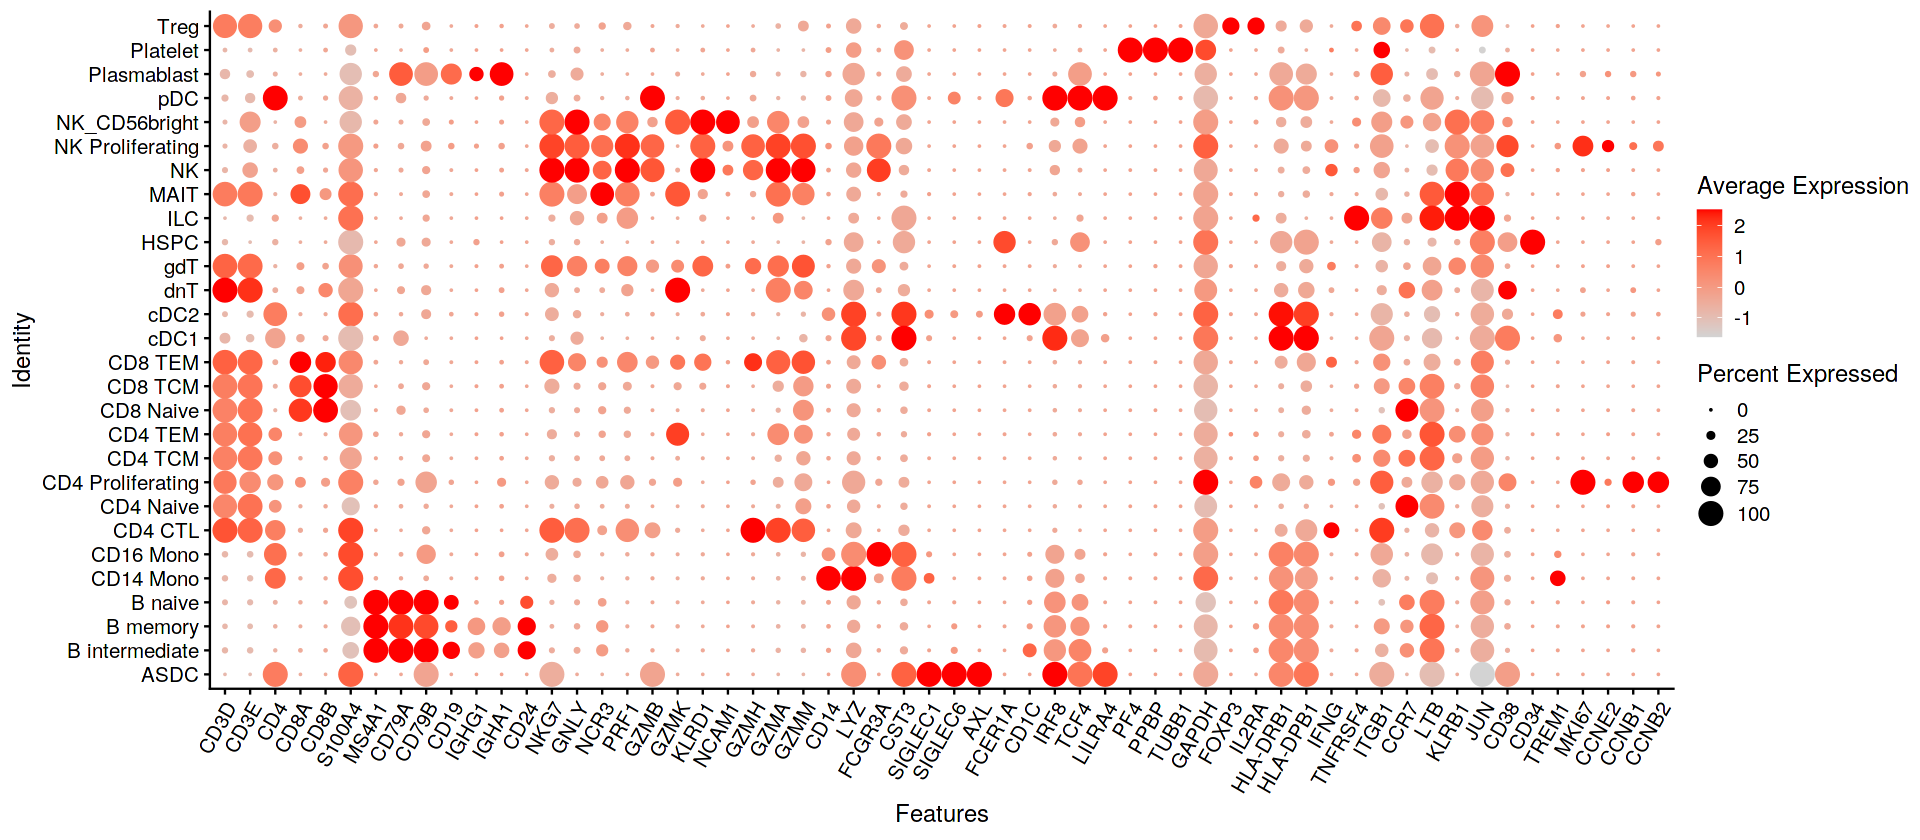

In [303]:
p = DotPlot(scRNA, features = rev( genelist.byHand ) , 
            group.by="predicted.id",
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=16, repr.plot.height=7)
p #这个效果简直是奇迹！十分的理想化！

* 区别
    - B: Bnaive /B memory /B intermediate /Plasmablast:?
    - DC: pDC /cDC1 /cDC2
    - CD8: TEM /TCM
    - CD4: TEM /TCM
    - DC: pDC /cDC

In [54]:
table(scRNA@meta.data$predicted.id)


             ASDC    B intermediate          B memory           B naive 
                1               303               175               441 
        CD14 Mono         CD16 Mono           CD4 CTL         CD4 Naive 
             3170               531                14               749 
CD4 Proliferating           CD4 TCM           CD4 TEM         CD8 Naive 
               12              1649                97              1224 
          CD8 TCM           CD8 TEM              cDC1              cDC2 
               82               513                 9               133 
              dnT               gdT              HSPC               ILC 
               10               151                 8                 6 
             MAIT                NK  NK Proliferating     NK_CD56bright 
               96               427                15                16 
              pDC       Plasmablast          Platelet              Treg 
              110                16               

## find marker

In [60]:
Idents(scRNA)="predicted.id"
head(scRNA@active.ident)

AAACCCAGTATCGTAC AAACCCAGTCGGTGAA AAACCCAGTTAGAAAC AAACCCAGTTATCTTC 
       CD14 Mono             MAIT        CD14 Mono               NK 
AAACCCAGTTGCCGAC AAACCCAGTTTCCCAC 
       CD14 Mono        CD14 Mono 
28 Levels: ASDC B intermediate B memory B naive CD14 Mono CD16 Mono ... Treg

In [56]:
pbmc.markers2 <- FindAllMarkers(scRNA, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
genes.marker2 = pbmc.markers2 %>% group_by(cluster) %>% top_n(n = 2, wt = avg_logFC) # long time! 20:35 - 20:
head(genes.marker2)

Calculating cluster ASDC

Calculating cluster B intermediate

Calculating cluster B memory

Calculating cluster B naive

Calculating cluster CD14 Mono

Calculating cluster CD16 Mono

Calculating cluster CD4 CTL

Calculating cluster CD4 Naive

Calculating cluster CD4 Proliferating

Calculating cluster CD4 TCM

Calculating cluster CD4 TEM

Calculating cluster CD8 Naive

Calculating cluster CD8 TCM

Calculating cluster CD8 TEM

Calculating cluster cDC1

Calculating cluster cDC2

Calculating cluster dnT

Calculating cluster gdT

Calculating cluster HSPC

Calculating cluster ILC

Calculating cluster MAIT

Calculating cluster NK

Calculating cluster NK Proliferating

Calculating cluster NK_CD56bright

Calculating cluster pDC

Calculating cluster Plasmablast

Calculating cluster Platelet

Calculating cluster Treg



p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster        gene 
1  0.000000e+00 2.343685  0.957 0.169  0.000000e+00 B intermediate IGHM 
2  0.000000e+00 2.097632  1.000 0.133  0.000000e+00 B intermediate CD79A
3 7.836608e-303 1.886141  1.000 0.103 1.791449e-298 B memory       MS4A1
4  7.652378e-58 1.895485  0.783 0.371  1.749334e-53 B memory       IGKC 
5  0.000000e+00 2.883023  0.998 0.156  0.000000e+00 B naive        IGHM 
6  0.000000e+00 2.439962  0.939 0.019  0.000000e+00 B naive        TCL1A

p_val         avg_logFC pct.1 pct.2 p_val_adj     cluster        gene 
1  0.000000e+00 2.343685  0.957 0.169  0.000000e+00 B intermediate IGHM 
2  0.000000e+00 2.097632  1.000 0.133  0.000000e+00 B intermediate CD79A
3  0.000000e+00 1.994178  0.993 0.092  0.000000e+00 B intermediate MS4A1
4 7.345820e-110 2.022961  0.799 0.365 1.679254e-105 B intermediate IGKC 
5 7.836608e-303 1.886141  1.000 0.103 1.791449e-298 B memory       MS4A1
6 3.711972e-222 1.784369  0.994 0.144 8.485568e-218 B memory       CD79A

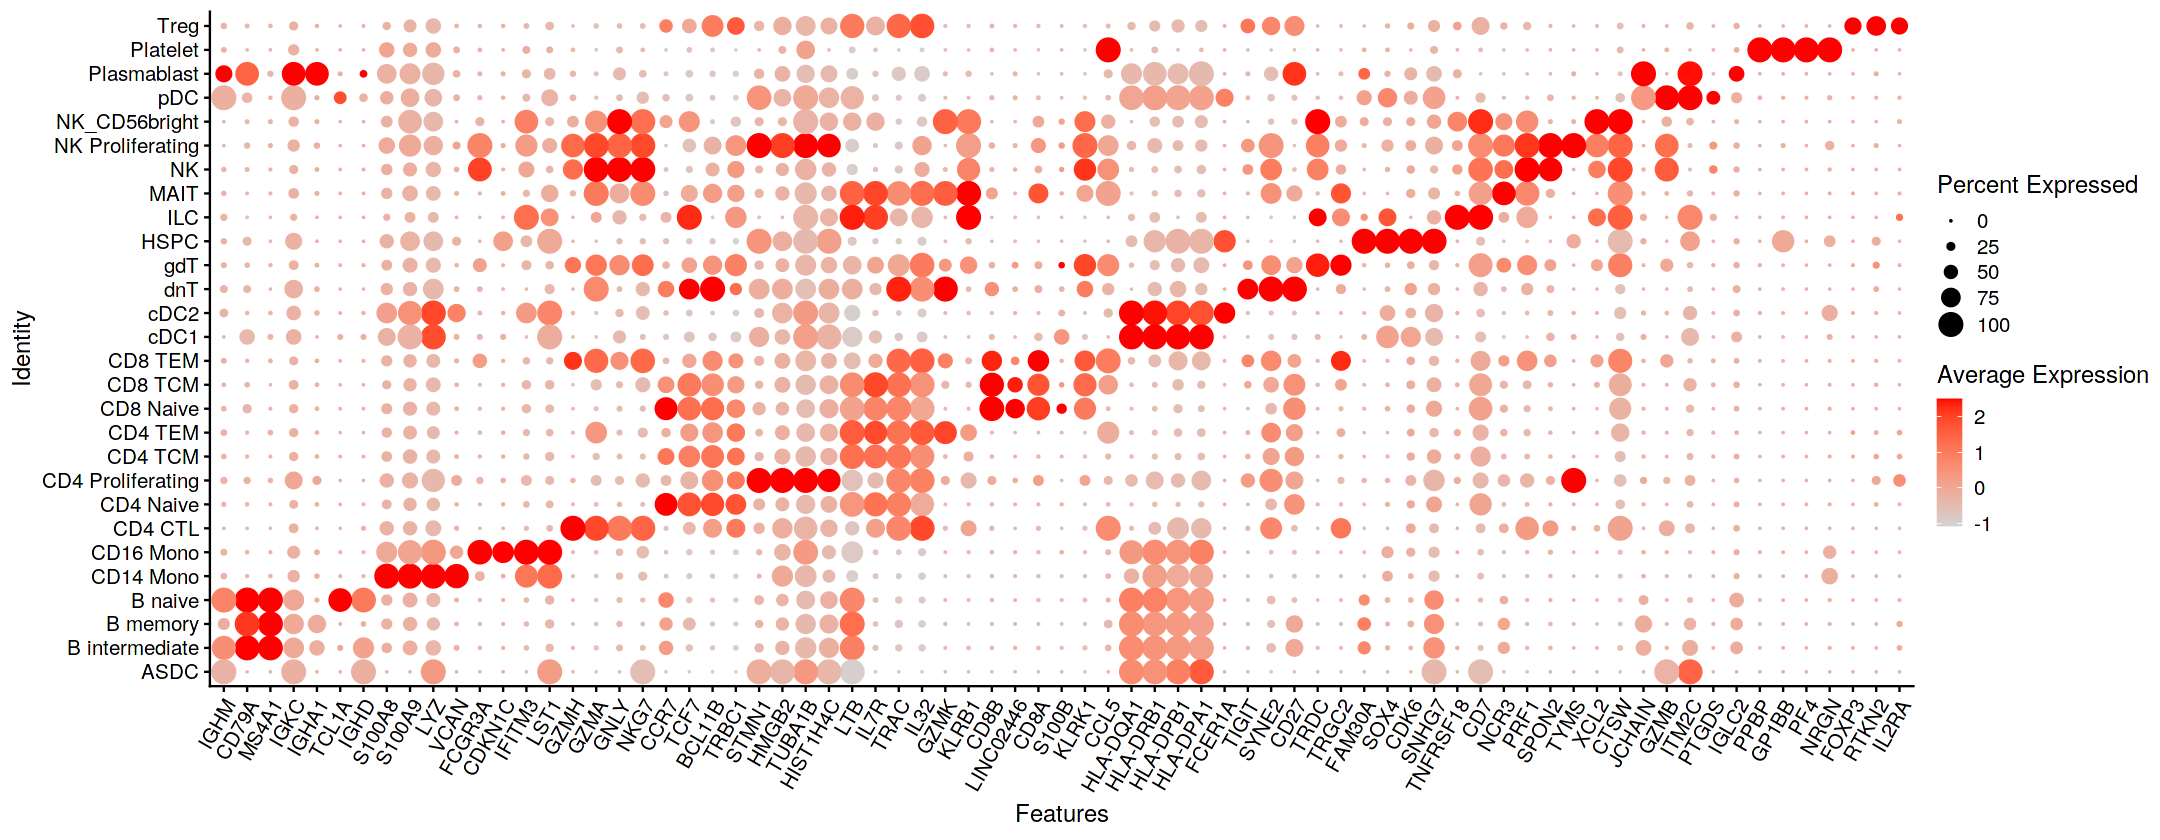

In [196]:
topN_ = pbmc.markers2 %>% group_by(cluster) %>% top_n(n = 4, wt = avg_logFC)
head(topN_)

p = DotPlot(scRNA, features = rev( unique( c(as.character(topN_$gene), "FOXP3") ) ) , 
            group.by="predicted.id",
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

options(repr.plot.width=18, repr.plot.height=7)
p #这个效果简直是奇迹！十分的理想化！

### Heatmap

[1] 270   7

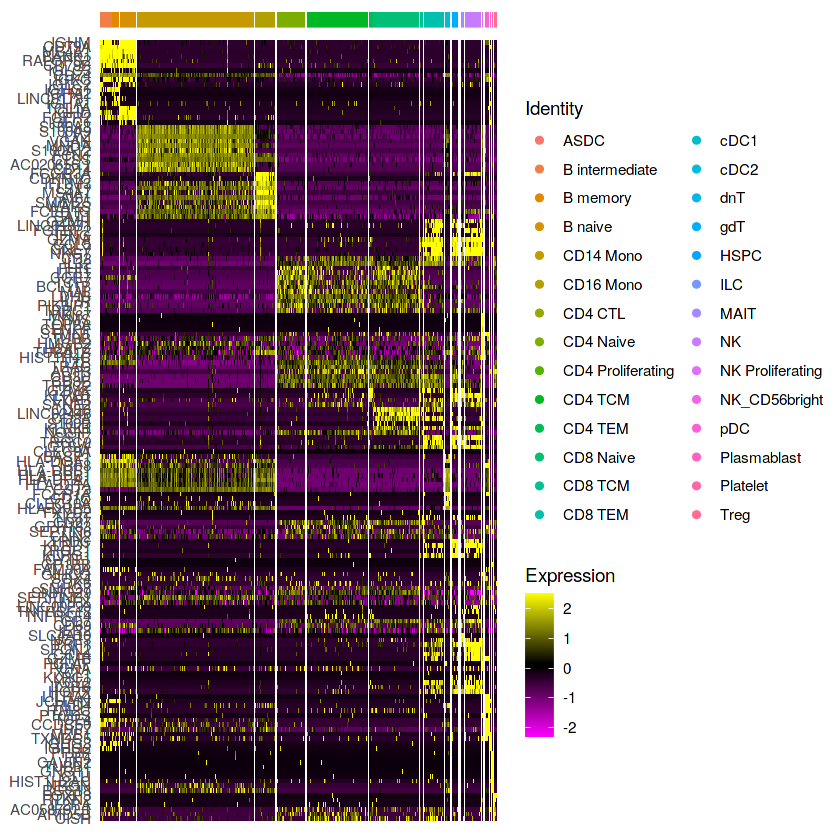

In [68]:
top10_ <- pbmc.markers2 %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
dim(top10_)
p1=DoHeatmap(scRNA, features = top10_$gene, label = F )

options(repr.plot.width=7, repr.plot.height=7)
p1
ggsave(paste0(outputRoot, "02_heatmap.pdf"), p1, width=8, height=20 )

[1] 270   7

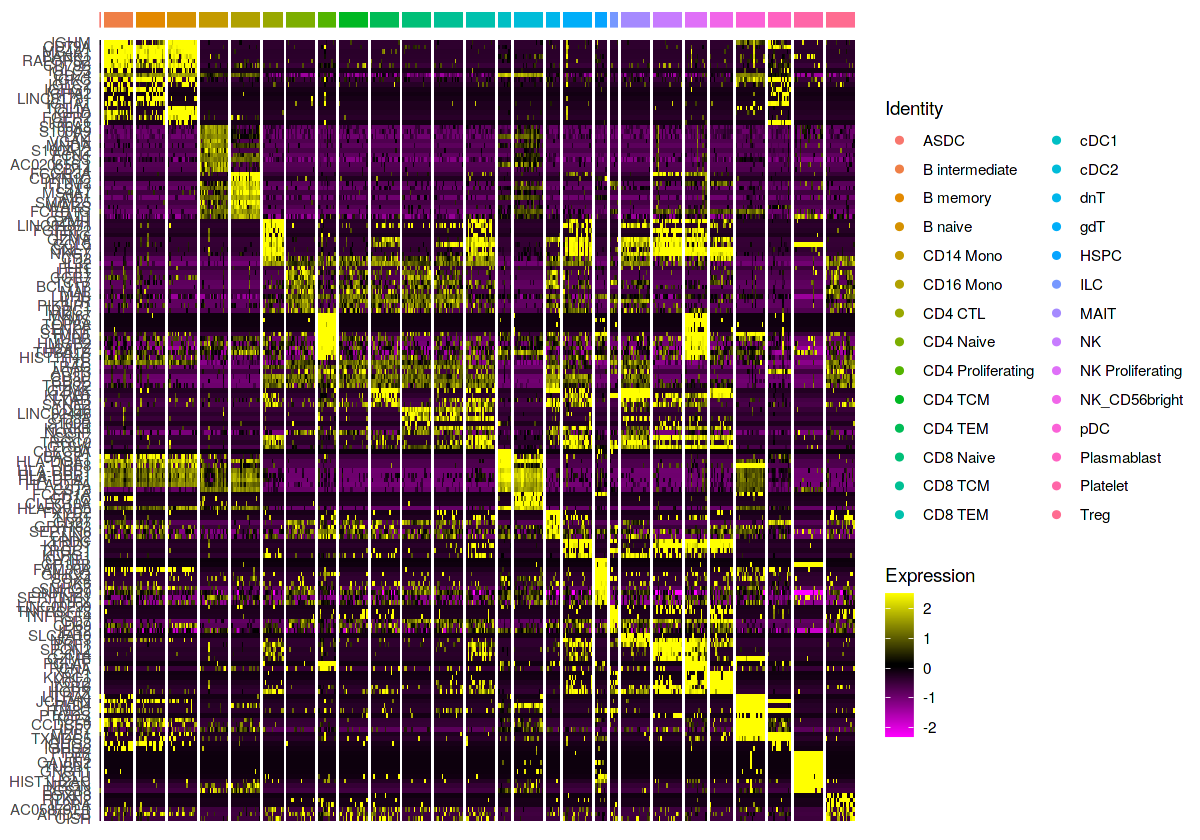

In [87]:
top10_ <- pbmc.markers2 %>% group_by(cluster) %>% top_n(n = 10, wt = avg_logFC)
dim(top10_)

set.seed(20210303)
p1=DoHeatmap( subset(scRNA, downsample=20), features = top10_$gene, label = F )

options(repr.plot.width=10, repr.plot.height=7)
p1
ggsave(paste0(outputRoot, "02_heatmap.pdf"), p1, width=8, height=20 )

### GAZA-H

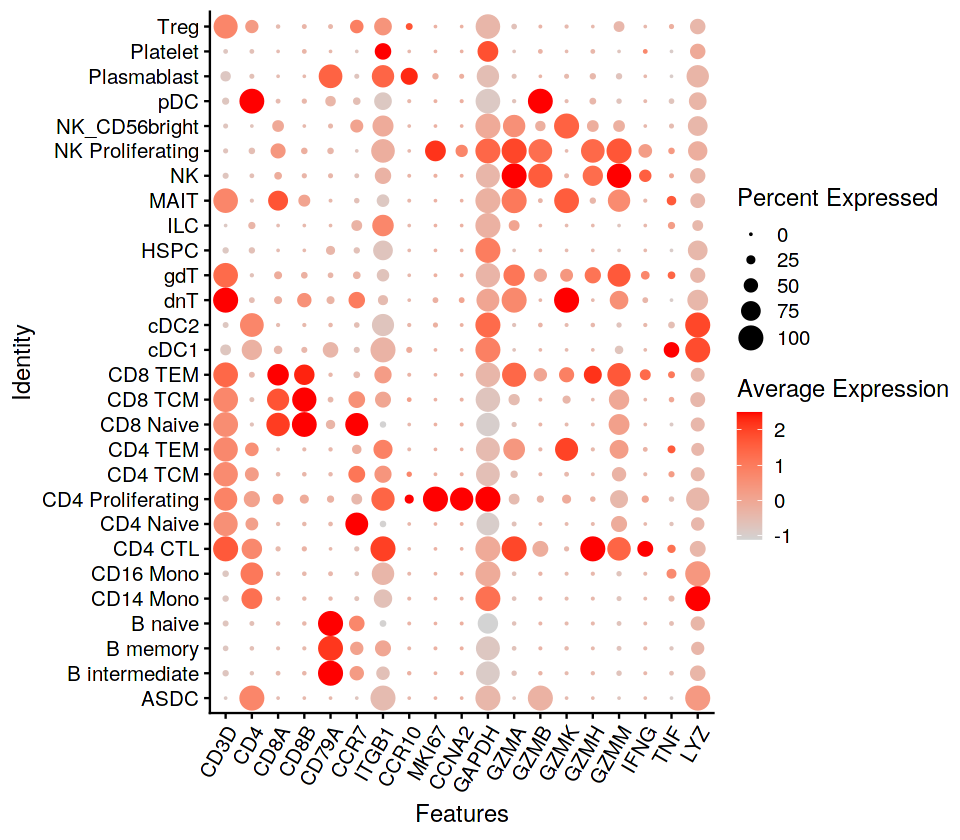

In [151]:
options(repr.plot.width=8, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B","CD79A", "CCR7","ITGB1", "CCR10", "MKI67","CCNA2", 
                                         "GAPDH",
                                         "GZMA",'GZMB','GZMK','GZMH','GZMM', "IFNG","TNF", "LYZ") )),
    cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### immuno repression

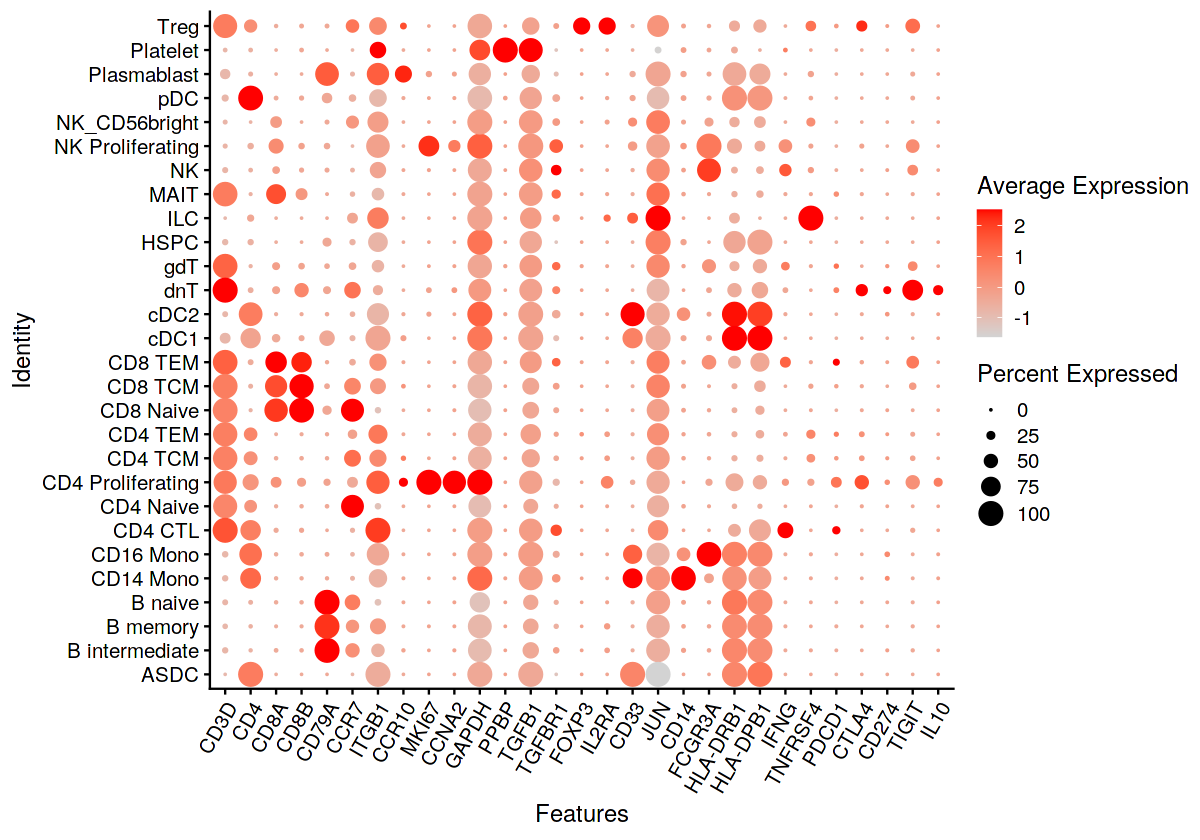

In [197]:
options(repr.plot.width=10, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B","CD79A", "CCR7","ITGB1", "CCR10", "MKI67","CCNA2", 
                                         "GAPDH", "PPBP","TGFB1","TGFBR1","FOXP3","IL2RA",# IL2RA(CD25)
                                         "CD33",#"MME", #"CD10",
                                         "JUN",
                                         "CD14","FCGR3A", #FCGR3A(CD16)
                                         "HLA-DRB1", "HLA-DPB1", "IFNG","TNFRSF4", #"OX40",
                                         "PDCD1", "CTLA4","CD274","TIGIT","IL10" ) )),
    cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

#### co expression

In [232]:
getCoExpression=function(geneOfIntrest="TIGIT", isShow=F){
    # step1
    sub=subset(scRNA, idents = c("dnT", "Treg")) #"CD4 Proliferating"
    matrix<-scRNA@assays$RNA@data
    matrix_mod<-as.matrix(matrix)
    dim(matrix_mod)
    # step2
    gene<-as.numeric(matrix_mod[geneOfIntrest,])
    length(gene)

    # step3
    correlations<-apply(matrix_mod,1,function(x){cor(gene,x, use="complete.obs", method = "spearman")})
    class(correlations)
    # rm NA
    correlations=correlations[!is.na(correlations)]

    # step4: to df 
    head(correlations)
    cor_df=data.frame(
        gene=names(correlations),
        cor=unname(correlations)
    )
    rownames(cor_df)=cor_df$gene
    cor_df=cor_df[order(-cor_df$cor),] #order
    if(isShow){
        head(cor_df,n=20)
        tail(cor_df)
    }
    return(cor_df)
}
cor_df=getCoExpression('TIGIT')

Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”
Warning message in cor(gene, x, use = "complete.obs", method = "spearman"):
“the standard deviation is zero”


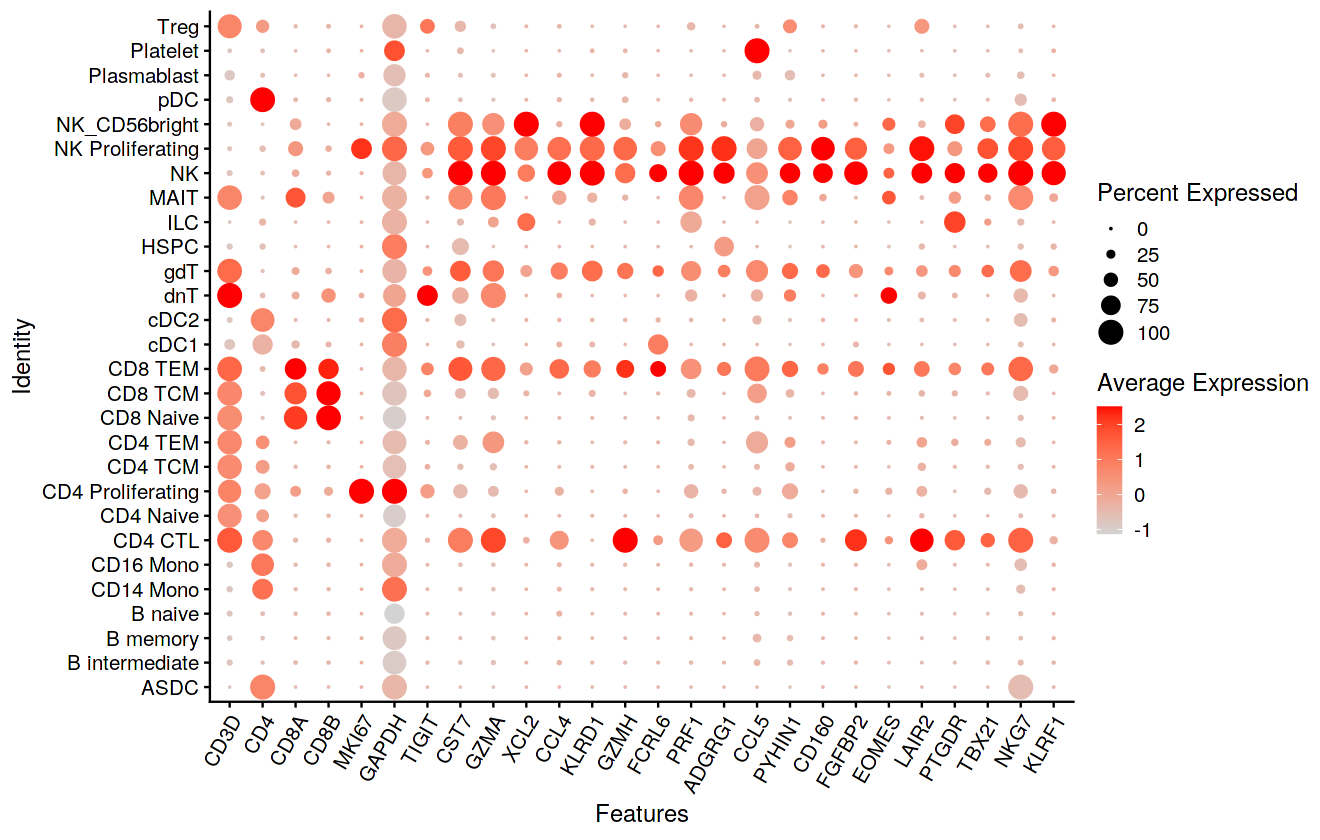

In [237]:
options(repr.plot.width=11, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B", "MKI67", #"GZMB", "CCR7","ITGB1", "CCR10", 
                                         "GAPDH",'TIGIT', 
                                         rownames( head(cor_df, n=20) )) ) ), 
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

## 两两比较

In [109]:
findSigMarker=function(scRNA, ident1=0, ident2=9, logFC_threshold=1 ){
    cat("cluster:",ident1, 'vs.', ident2, "\n")
    markers.2=FindMarkers(scRNA, ident.1=ident1, ident.2 =ident2 )
    top10.2 = markers.2 %>% filter(p_val_adj<0.05 & abs(avg_logFC) > logFC_threshold ) 
        #top_n(n = 10, wt = avg_logFC)
    print(dim(top10.2))
    print(head(top10.2))
    top10.2
}

### CD8 TEM vs TCM

In [160]:
rs=findSigMarker(scRNA, "CD8 TEM","CD8 TCM",0.9)
rs

cluster: CD8 TEM vs. CD8 TCM 
[1] 25  5
            p_val avg_logFC pct.1 pct.2    p_val_adj
NKG7 5.115878e-42  2.697090 0.979 0.537 1.169490e-37
CST7 2.240874e-40  1.901846 0.949 0.329 5.122637e-36
GZMA 2.572254e-39  1.968956 0.959 0.354 5.880172e-35
IL7R 5.182554e-31 -1.156112 0.495 1.000 1.184732e-26
PLEK 2.915709e-29  1.384023 0.774 0.037 6.665311e-25
CCL4 2.383858e-28  1.695827 0.745 0.012 5.449499e-24


p_val        avg_logFC  pct.1 pct.2 p_val_adj   
NKG7     5.115878e-42  2.6970901 0.979 0.537 1.169490e-37
CST7     2.240874e-40  1.9018463 0.949 0.329 5.122637e-36
GZMA     2.572254e-39  1.9689561 0.959 0.354 5.880172e-35
IL7R     5.182554e-31 -1.1561118 0.495 1.000 1.184732e-26
PLEK     2.915709e-29  1.3840228 0.774 0.037 6.665311e-25
CCL4     2.383858e-28  1.6958273 0.745 0.012 5.449499e-24
KLRG1    3.464292e-28  1.3641949 0.823 0.232 7.919373e-24
LTB      3.059317e-27 -1.0124508 0.620 0.988 6.993598e-23
PRF1     1.168105e-25  1.4486953 0.793 0.244 2.670289e-21
GZMH     4.460399e-24  2.3904632 0.669 0.000 1.019647e-19
EFHD2    2.609431e-23  1.2825329 0.723 0.134 5.965160e-19
ZEB2     4.889142e-21  1.1970923 0.661 0.073 1.117658e-16
GNLY     4.681098e-20  3.0726762 0.674 0.159 1.070099e-15
HLA-DPA1 7.189172e-20  0.9232557 0.712 0.220 1.643445e-15
CTSC     9.346567e-19  0.9406605 0.791 0.415 2.136625e-14
FGFBP2   6.106405e-18  1.6799816 0.571 0.037 1.395924e-13
FCRL6    1.032412e-17  0.9175326 0.567 0.024 2.360093e-13
KLRD1    1.216322e-17  1.5911929 0.635 0.159 2.780512e-13
TRGC2    2.555222e-16  1.0080496 0.762 0.378 5.841237e-12
FCGR3A   8.089383e-16  1.1819768 0.509 0.012 1.849233e-11
LAIR2    1.067671e-13  0.9289541 0.565 0.134 2.440695e-09
GZMB     1.798268e-13  1.2120784 0.452 0.012 4.110840e-09
CMC1     5.246119e-12  1.0473765 0.596 0.268 1.199263e-07
GZMK     9.950035e-11  1.6090381 0.536 0.207 2.274578e-06
LGALS1   3.674288e-08  0.9866809 0.620 0.402 8.399423e-04

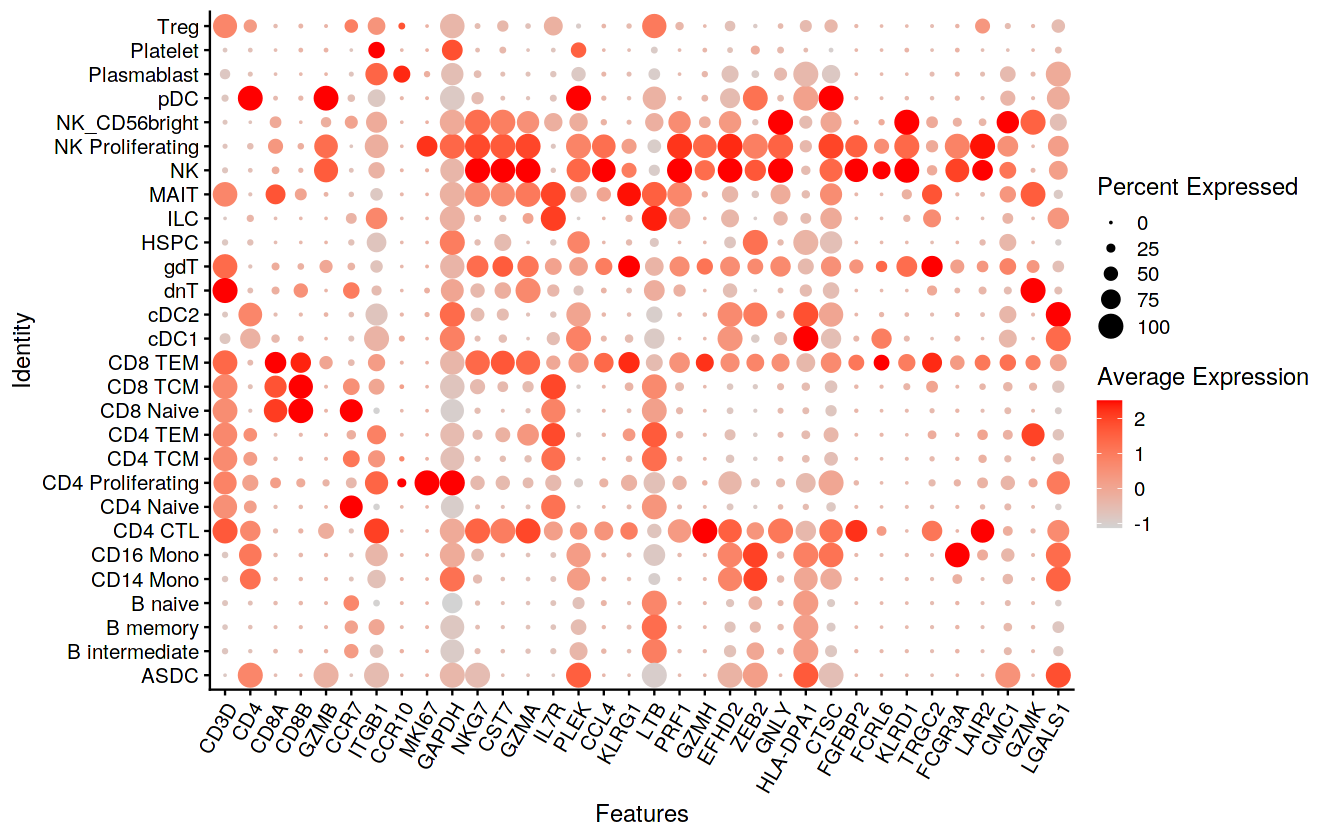

In [161]:
options(repr.plot.width=11, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B","GZMB", "CCR7","ITGB1", "CCR10", "MKI67", 
                                         "GAPDH", rownames(rs)) ) ), 
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

> KLRG1, 

### CD4 TEM vs TCM

In [167]:
rs2=findSigMarker(scRNA, "CD4 TEM","CD4 TCM",0.6)
rs2

cluster: CD4 TEM vs. CD4 TCM 
[1] 8 5
              p_val avg_logFC pct.1 pct.2     p_val_adj
GZMK  1.605189e-180 2.4186392 0.907 0.052 3.669462e-176
CCL5  9.983325e-101 1.8314057 0.866 0.116  2.282188e-96
GZMA   1.704416e-69 1.5679095 0.845 0.172  3.896295e-65
LYAR   6.595803e-32 0.7881520 0.722 0.244  1.507801e-27
CST7   1.415500e-29 0.6947046 0.526 0.128  3.235833e-25
KLRG1  1.342353e-16 0.6035396 0.423 0.134  3.068620e-12


p_val         avg_logFC  pct.1 pct.2 p_val_adj    
GZMK  1.605189e-180  2.4186392 0.907 0.052 3.669462e-176
CCL5  9.983325e-101  1.8314057 0.866 0.116  2.282188e-96
GZMA   1.704416e-69  1.5679095 0.845 0.172  3.896295e-65
LYAR   6.595803e-32  0.7881520 0.722 0.244  1.507801e-27
CST7   1.415500e-29  0.6947046 0.526 0.128  3.235833e-25
KLRG1  1.342353e-16  0.6035396 0.423 0.134  3.068620e-12
KLRB1  6.178945e-13  0.7181286 0.608 0.300  1.412507e-08
CCR7   8.688254e-12 -0.6110787 0.268 0.616  1.986135e-07

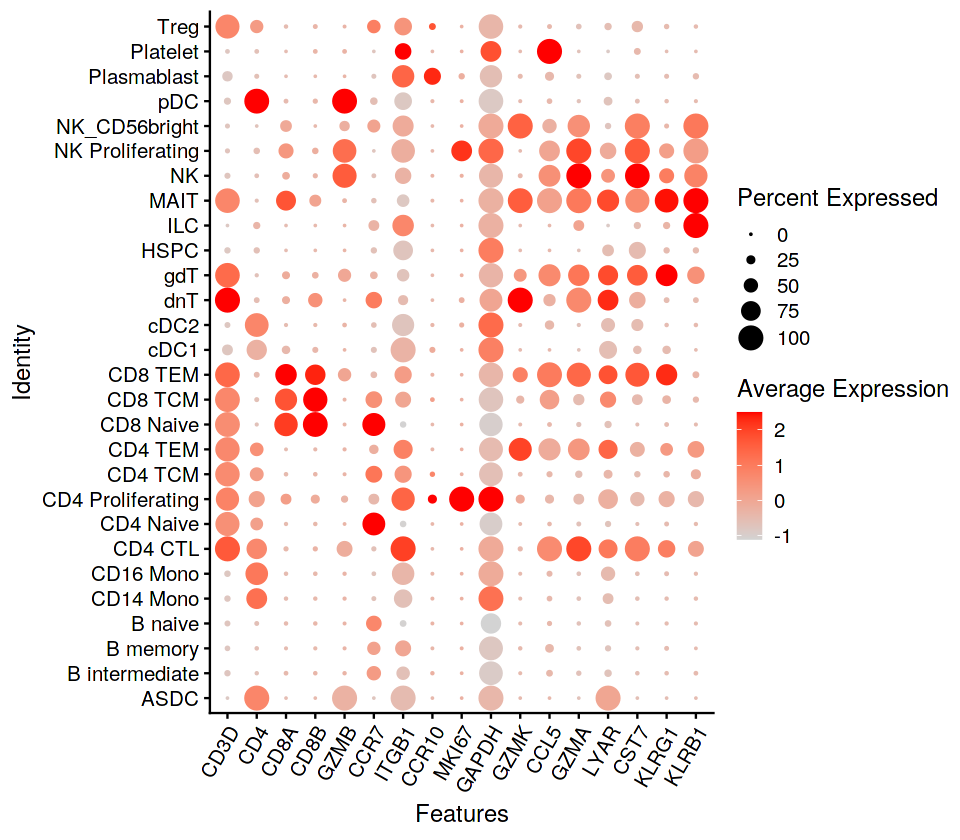

In [168]:
options(repr.plot.width=8, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B","GZMB", "CCR7","ITGB1", "CCR10", "MKI67",
                                         "GAPDH", rownames(rs2)) ) ), 
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

> GZMK

### B cells

In [283]:
rs3=findSigMarker(scRNA, "B memory","B intermediate",0.6)
rs3

cluster: B memory vs. B intermediate 
[1] 10  5
                 p_val  avg_logFC pct.1 pct.2    p_val_adj
IGHM      1.071535e-57 -2.1038031 0.389 0.957 2.449530e-53
IGHD      3.088337e-47 -0.9849271 0.091 0.822 7.059937e-43
COCH      1.831932e-35  0.8905242 0.577 0.069 4.187796e-31
LINC01857 4.788804e-29 -0.8044246 0.229 0.746 1.094721e-24
LINC01781 7.121652e-27  0.9134364 0.669 0.201 1.628010e-22
SSPN      3.694617e-24  0.6729809 0.566 0.145 8.445894e-20


p_val        avg_logFC  pct.1 pct.2 p_val_adj   
IGHM      1.071535e-57 -2.1038031 0.389 0.957 2.449530e-53
IGHD      3.088337e-47 -0.9849271 0.091 0.822 7.059937e-43
COCH      1.831932e-35  0.8905242 0.577 0.069 4.187796e-31
LINC01857 4.788804e-29 -0.8044246 0.229 0.746 1.094721e-24
LINC01781 7.121652e-27  0.9134364 0.669 0.201 1.628010e-22
SSPN      3.694617e-24  0.6729809 0.566 0.145 8.445894e-20
IGHA2     2.821360e-18  1.1945600 0.440 0.116 6.449629e-14
CD1C      1.440600e-16 -0.6208316 0.114 0.479 3.293212e-12
IGHA1     6.802512e-09  1.1075477 0.686 0.551 1.555054e-04
IGHG1     7.364946e-09  0.9296327 0.651 0.591 1.683627e-04

In [292]:
rs3_2=findSigMarker(scRNA, c("B memory","B intermediate"), c("Plasmablast"), 0.8)
head(rs3_2)

cluster: B memory B intermediate vs. Plasmablast 
[1] 188   5
              p_val  avg_logFC pct.1 pct.2    p_val_adj
AQP3   4.059966e-53 -1.5777632 0.038 1.000 9.281082e-49
PRDM1  1.157188e-49 -0.8388780 0.040 1.000 2.645332e-45
SLAMF7 3.344184e-48 -0.9259100 0.029 0.875 7.644804e-44
CD59   1.098904e-34 -0.9434719 0.073 1.000 2.512094e-30
CD38   4.456632e-29 -1.1897365 0.094 1.000 1.018786e-24
MAN1A1 4.021416e-28 -0.9885888 0.084 0.938 9.192956e-24


p_val        avg_logFC  pct.1 pct.2 p_val_adj   
AQP3   4.059966e-53 -1.5777632 0.038 1.000 9.281082e-49
PRDM1  1.157188e-49 -0.8388780 0.040 1.000 2.645332e-45
SLAMF7 3.344184e-48 -0.9259100 0.029 0.875 7.644804e-44
CD59   1.098904e-34 -0.9434719 0.073 1.000 2.512094e-30
CD38   4.456632e-29 -1.1897365 0.094 1.000 1.018786e-24
MAN1A1 4.021416e-28 -0.9885888 0.084 0.938 9.192956e-24

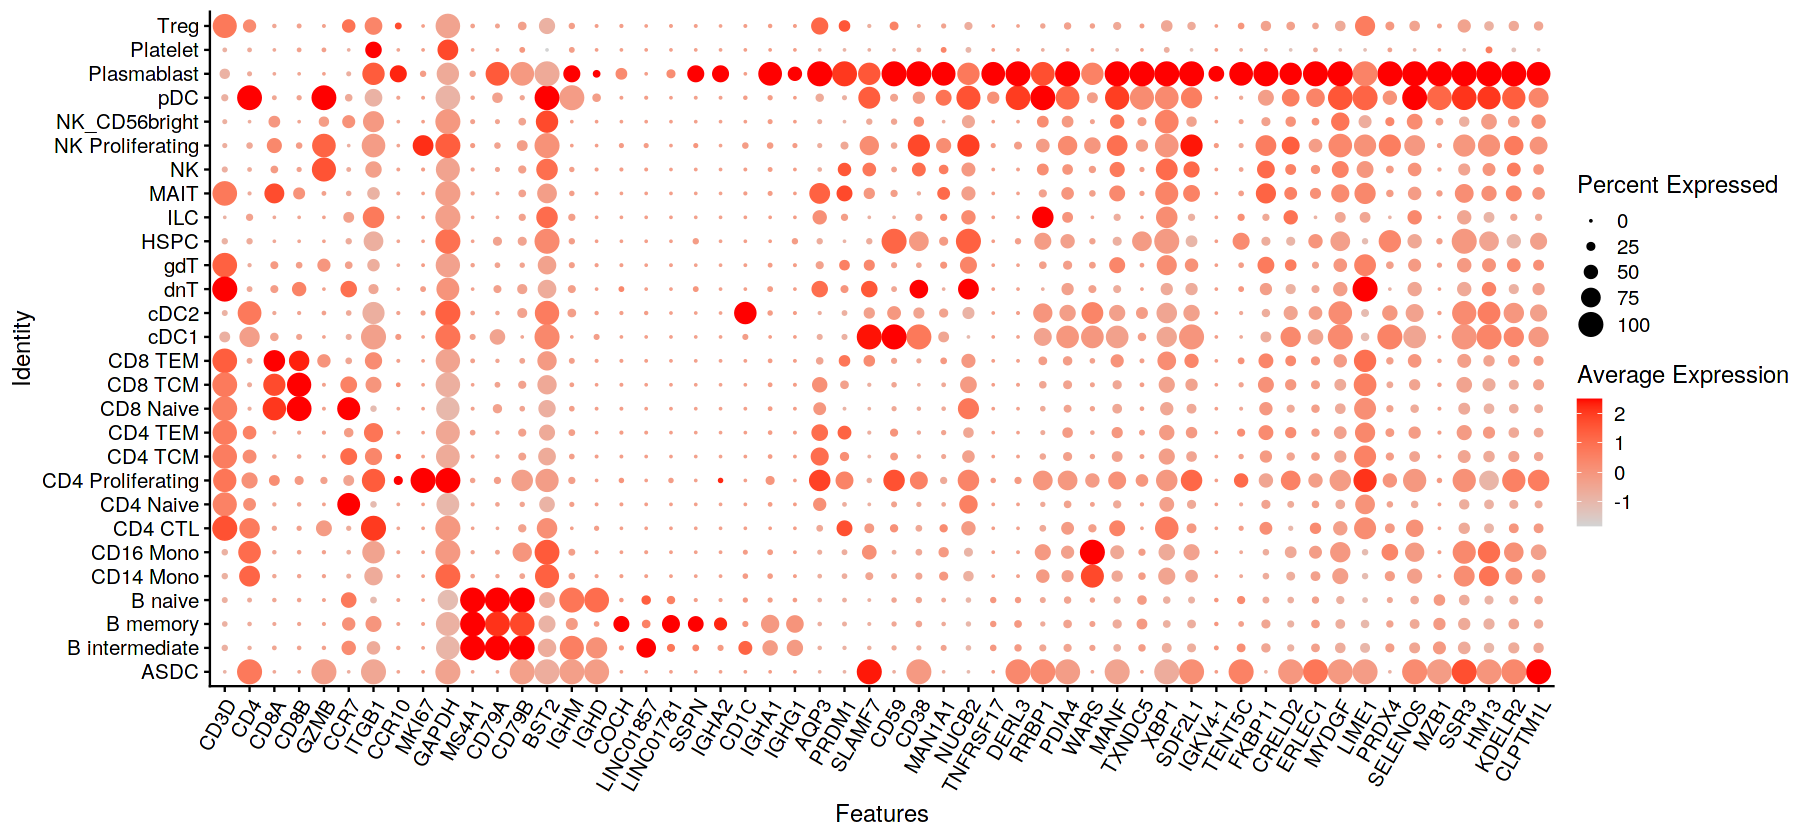

In [304]:
options(repr.plot.width=15, repr.plot.height=7)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B",   "GZMB", "CCR7","ITGB1", "CCR10", "MKI67",
                                         "GAPDH","MS4A1","CD79A","CD79B","BST2", rownames(rs3), rownames(rs3_2[1:30,]) ) ) ), 
            cols = c("lightgrey", "red"))+ #自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### pDC vs cDC, cDC(1,2)

In [309]:
rs4=findSigMarker(scRNA, c("cDC1","cDC2"), "pDC",0.8)
head(rs4)

cluster: cDC1 cDC2 vs. pDC 
[1] 203   5
               p_val avg_logFC pct.1 pct.2    p_val_adj
SCT     4.395654e-50 -1.784636 0.007 0.991 1.004846e-45
NIBAN3  9.035979e-50 -1.466429 0.014 0.991 2.065625e-45
LILRA4  1.035229e-49 -2.432986 0.042 1.000 2.366534e-45
MZB1    2.080645e-49 -2.045717 0.028 0.991 4.756355e-45
TSPAN13 3.879037e-49 -1.757707 0.028 0.991 8.867478e-45
DERL3   5.064019e-49 -1.381791 0.014 0.982 1.157635e-44


p_val        avg_logFC pct.1 pct.2 p_val_adj   
SCT     4.395654e-50 -1.784636 0.007 0.991 1.004846e-45
NIBAN3  9.035979e-50 -1.466429 0.014 0.991 2.065625e-45
LILRA4  1.035229e-49 -2.432986 0.042 1.000 2.366534e-45
MZB1    2.080645e-49 -2.045717 0.028 0.991 4.756355e-45
TSPAN13 3.879037e-49 -1.757707 0.028 0.991 8.867478e-45
DERL3   5.064019e-49 -1.381791 0.014 0.982 1.157635e-44

In [310]:
rs4_2=findSigMarker(scRNA, "cDC1","cDC2",0.8)
head(rs4_2)

cluster: cDC1 vs. cDC2 
[1] 22  5
                p_val avg_logFC pct.1 pct.2    p_val_adj
CLNK     1.962616e-23 1.0222168 1.000 0.030 4.486540e-19
CLEC9A   2.626339e-17 2.0406549 1.000 0.075 6.003812e-13
C1orf54  2.705532e-12 1.6740340 1.000 0.158 6.184845e-08
DNASE1L3 2.157318e-11 1.5360356 0.889 0.105 4.931629e-07
HLA-DOB  3.199647e-09 0.8532009 1.000 0.256 7.314394e-05
RGCC     2.120308e-08 1.0403428 1.000 0.286 4.847023e-04


p_val        avg_logFC pct.1 pct.2 p_val_adj   
CLNK     1.962616e-23 1.0222168 1.000 0.030 4.486540e-19
CLEC9A   2.626339e-17 2.0406549 1.000 0.075 6.003812e-13
C1orf54  2.705532e-12 1.6740340 1.000 0.158 6.184845e-08
DNASE1L3 2.157318e-11 1.5360356 0.889 0.105 4.931629e-07
HLA-DOB  3.199647e-09 0.8532009 1.000 0.256 7.314394e-05
RGCC     2.120308e-08 1.0403428 1.000 0.286 4.847023e-04

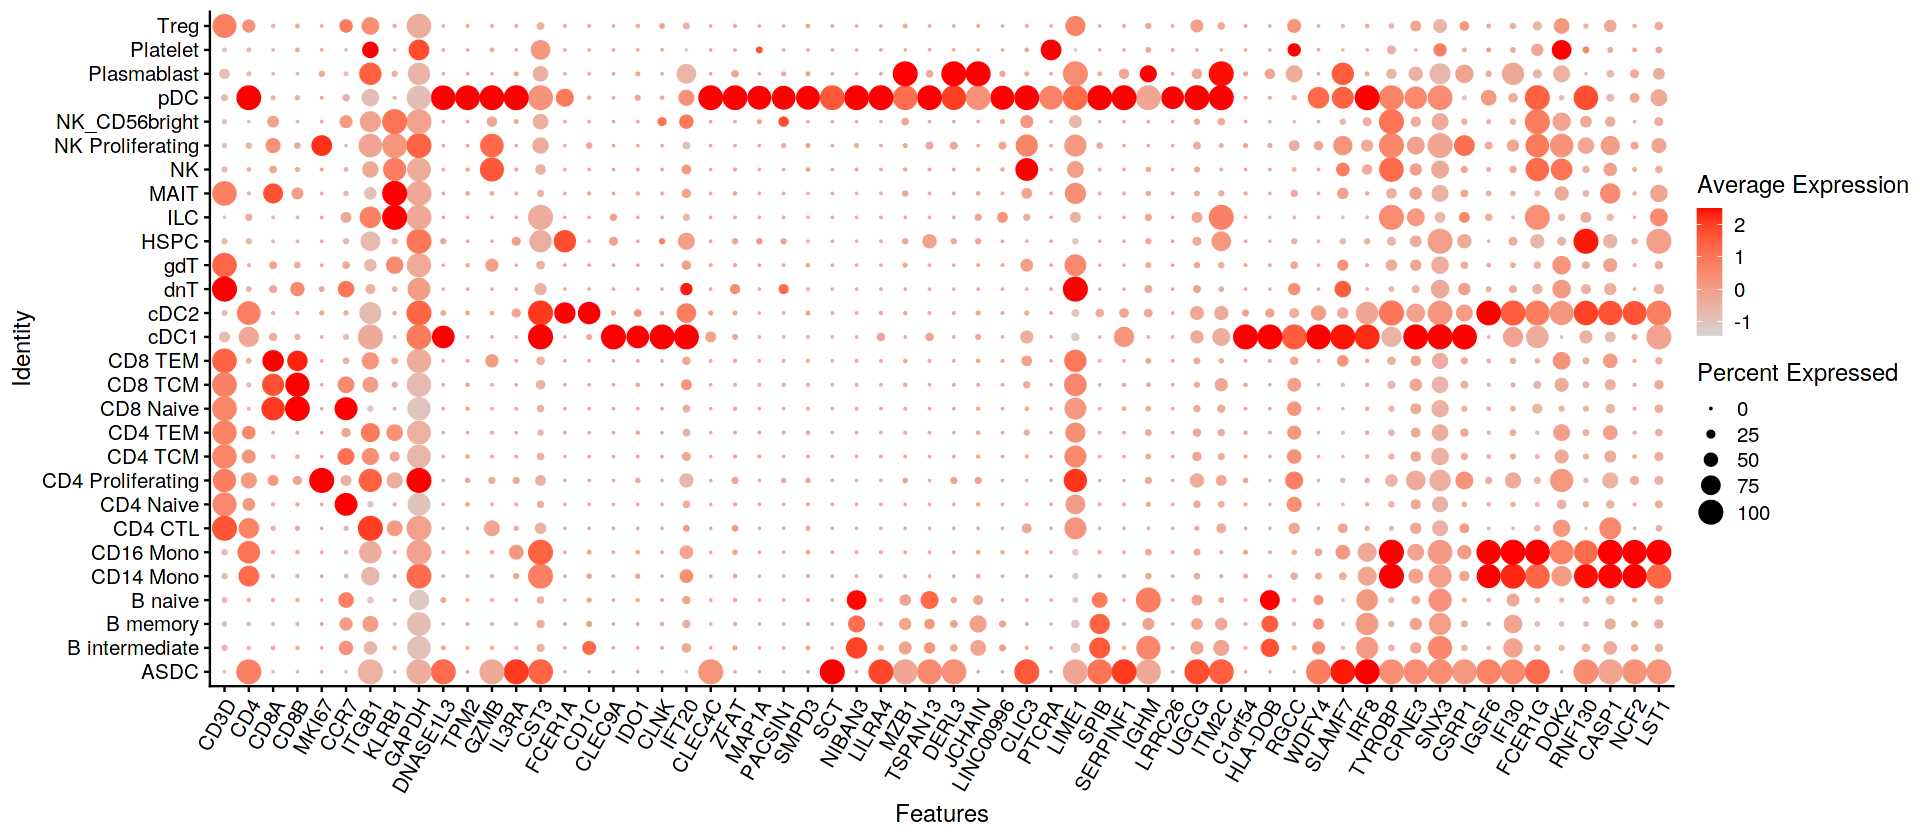

In [345]:
options(repr.plot.width=16, repr.plot.height=7) # , CD123(IL3RA)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B", "MKI67", "CCR7","ITGB1","KLRB1", #"GZMB",  "CCR10", 
                                         "GAPDH", "DNASE1L3", "TPM2", #?
                                         "GZMB","IL3RA", #pDC
                                         "CST3",  "FCER1A","CD1C",  #(mDC) cDC2
                                         "CLEC9A", "IDO1", "CLNK", #cDC1
                                         "IFT20", "CLEC4C",'ZFAT',"MAP1A", "PACSIN1", "SMPD3", #?
                                         rownames(rs4[1:25,]), rownames(rs4_2) ) ) ), 
            cols = c("lightgrey", "red"))+ # 自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

### MAIT 

In [357]:
rs5=findSigMarker(scRNA, c("CD8 TEM","CD8 TCM"), "MAIT",0.7)
head(rs5)
tail(rs5)

cluster: CD8 TEM CD8 TCM vs. MAIT 
[1] 31  5
                p_val  avg_logFC pct.1 pct.2     p_val_adj
SLC4A10 1.388163e-121 -1.1838818 0.002 0.833 3.173340e-117
KLRB1    1.797915e-89 -2.5764825 0.146 1.000  4.110035e-85
CEBPD    1.893848e-85 -1.2501545 0.037 0.771  4.329335e-81
ZBTB16   3.132719e-79 -0.8859758 0.025 0.688  7.161395e-75
NCR3     2.337855e-45 -1.2955260 0.328 0.938  5.344337e-41
AQP3     1.511429e-36 -0.8250623 0.232 0.802  3.455126e-32


p_val         avg_logFC  pct.1 pct.2 p_val_adj    
SLC4A10 1.388163e-121 -1.1838818 0.002 0.833 3.173340e-117
KLRB1    1.797915e-89 -2.5764825 0.146 1.000  4.110035e-85
CEBPD    1.893848e-85 -1.2501545 0.037 0.771  4.329335e-81
ZBTB16   3.132719e-79 -0.8859758 0.025 0.688  7.161395e-75
NCR3     2.337855e-45 -1.2955260 0.328 0.938  5.344337e-41
AQP3     1.511429e-36 -0.8250623 0.232 0.802  3.455126e-32

p_val        avg_logFC pct.1 pct.2 p_val_adj   
LGALS1 1.973071e-12 1.1910117 0.590 0.260 4.510440e-08
GZMB   3.544467e-11 1.0542359 0.392 0.052 8.102652e-07
KLRD1  5.771294e-11 1.1707548 0.570 0.302 1.319318e-06
ITGB1  4.418003e-10 0.7606480 0.627 0.417 1.009955e-05
IFNG   1.905632e-08 0.7056528 0.291 0.021 4.356274e-04
CCL4   5.212007e-08 0.8273641 0.644 0.500 1.191465e-03

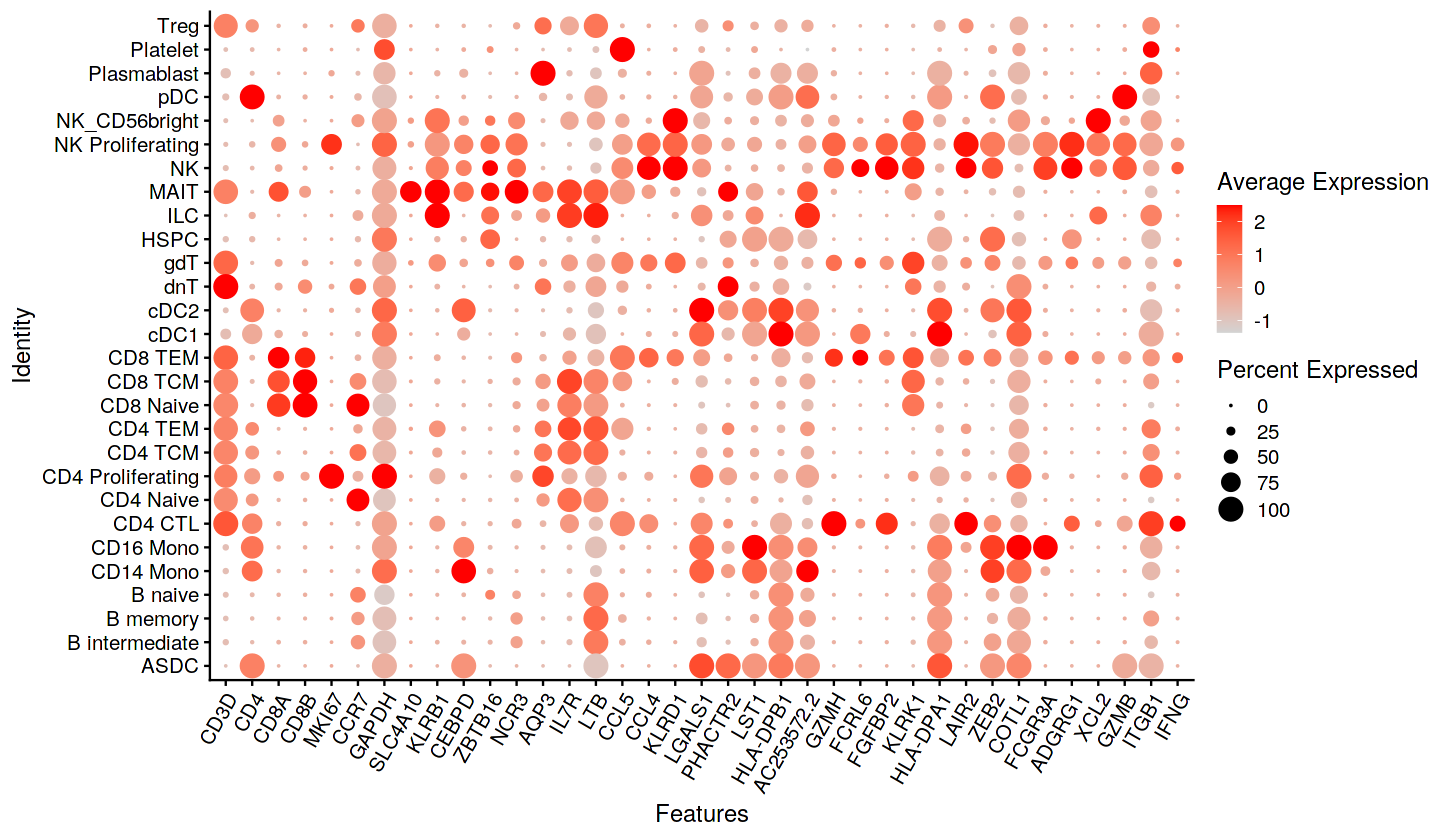

In [362]:
options(repr.plot.width=12, repr.plot.height=7) # , CD123(IL3RA)
DotPlot(scRNA, features = rev( unique( c("CD3D","CD4","CD8A","CD8B", "MKI67", "CCR7", #"GZMB", "CCR10",  "ITGB1",
                                         "GAPDH", 
                                         "SLC4A10","KLRB1","CEBPD","ZBTB16","NCR3","AQP3", #MATI
                                         "IL7R","LTB", "CCL5", "CCL4", "KLRD1","LGALS1",# CD8 T
                                         rownames(rs5) ) ) ), 
            cols = c("lightgrey", "red"))+ # 自定义颜色
    theme( axis.text.x = element_text(angle = 60, vjust = 1, hjust = 1) )

## save

In [363]:
saveRDS(scRNA, file = paste0(outputRoot,"pbmc10k_addServer_final.rds") ) #long time: 2min